<h1><center>CSCI 4146/6409 - Process of Data Science (Summer 2024)</h1></center>





### 1. Data Exploration and Feature Engineering <a id='top'></a>

#### Dataset: Telco Customer Churn - https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data <a href="#1">

#### Importing Necessary Libraries/Dependencies

In [ ]:
!pip install lime plotly alibi

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import warnings
import numpy as np
from scipy import stats
import statsmodels.api as sm
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.feature_selection import SelectKBest, chi2
from IPython.display import display, HTML
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, average_precision_score, accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import IsolationForest, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_fscore_support,
    roc_auc_score,
    classification_report,
    average_precision_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score
)
from imblearn.metrics import geometric_mean_score
# from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support, average_precision_score, accuracy_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
import joblib
import lime
import lime.lime_tabular
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import re
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

#### Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# /content/drive/MyDrive/Telco-Dataset.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv"
# file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

#### I. Exploratory Data Analysis (EDA)

#### Utility Functions to Get the Data Quality of the Given Dataset

In [ ]:
# Completeness (Percentage of missing values)
def getDataCompleteness(df : pd.DataFrame):
    missing_values_count = df.isnull().sum()
    total_records = len(df)
    completeness = (missing_values_count / total_records) * 100
    completeness_df = pd.DataFrame({'Feature': missing_values_count.index,
        'Missing Values (%)': completeness.values.round(2)})
    return completeness_df

In [ ]:
# Uniqueness (Identification of Duplicate Records)
# Duplicate Records in Each Row
def getDataUniqueness(df: pd.DataFrame):
    total_records = len(df)
    duplicated_count = df.duplicated().sum()
    duplicates_data = pd.DataFrame({
        'Total Records': [total_records],
        'Duplicate Records': [duplicated_count]
    })
    return duplicates_data

In [ ]:
# Consistency (Validity of data formats and logical rules)
def getDataConsistency(df: pd.DataFrame):
    validity_count = {}

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            # For numerical columns, check for valid numeric values
            valid_values = pd.to_numeric(df[column], errors='coerce').notnull().sum()
        else:
            # For non-numeric columns, consider only non-null values as valid
            valid_values = df[column].notnull().sum()
        validity_count[column] = valid_values

    # Convert validity count dictionary to DataFrame
    validity_df = pd.DataFrame(validity_count.items(), columns=['Feature',
                'Valid Values Count'])
    return validity_df

In [ ]:
# Finding/Detecting outliers in the data
def getOutliers(df, z_thresh=3.5):
    outlier_counts = []

    for col in df.select_dtypes(include=[np.number]):
        median = df[col].median()
        std = df[col].std()

        z_scores = (df[col] - median) / std

        outliers_count = np.sum(np.abs(z_scores) > z_thresh)

        outlier_counts.append((col, outliers_count))

    summary_df = pd.DataFrame(outlier_counts, columns=['Feature',
        'Outlier Count'])

    return summary_df

#### Data Quality Plan Execution

#### Utility Funtions to Fix the Data Quality Issues and Data Preparation

In [ ]:
# 1. Handling Missing Values

def fixMissingValues(df):
    # Drop features with more than 30% missing values if necessary
    threshold = 0.3
    missing_percentage = df.isnull().mean()
    cols_to_drop = missing_percentage[missing_percentage > threshold].index
    df.drop(columns=cols_to_drop, inplace=True)

    num_features = df.select_dtypes(include=['float64', 'int']).columns.tolist()
    cat_features = df.select_dtypes(include=['object']).columns.tolist()

    # Fill NaN values in TotalCharges with 0 (assuming that could be a valid placeholder)
    df['TotalCharges'].fillna(0, inplace=True)

    # Impute missing values for numerical features using mean imputation
    num_imputer = SimpleImputer(strategy='mean')
    df[num_features] = num_imputer.fit_transform(df[num_features])

    # Impute missing values for categorical features using the most frequent value
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_features] = cat_imputer.fit_transform(df[cat_features])

    return df

In [ ]:
# 2. Ensuring Validity of Data Formats and Logical Rules

def fixDataValidity(df):
    for col in df.columns:
        # Check if the column contains numeric data
        if df[col].dtype == 'int64':
            # Convert to integer
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
        elif df[col].dtype == 'float64':
            # Convert to float
            df[col] = pd.to_numeric(df[col], errors='coerce')
        elif df[col].dtype == 'string':
            # Convert to string
            df[col] = df[col].astype('str')
    return df

In [ ]:
# 3. Fixing Outliers by Winsorizing

def fixOutliers(df, z_thresh=4.0):
    for col in df.select_dtypes(include=[np.number]):
        median = df[col].median()
        std = df[col].std()
        z_scores = (df[col] - median) / std
        outliers = df[np.abs(z_scores) > z_thresh]

        # Winsorization: Replace outliers with nearest non-outlier within IQR bounds
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # Winsorize lower outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Apply the bounds to outliers
        df[col] = np.where(df[col] < lower_bound, lower_bound, np.where(df[col] > upper_bound, upper_bound, df[col]))

    return df

In [ ]:
# 4. Ensuring there are no Duplicates in the Data

def fixDuplicateRecords(df):
    # Check for duplicate records
    num_duplicates = df.duplicated().sum()

    if num_duplicates > 0:
        # Remove duplicate records
        df = df.drop_duplicates()
    return df

In [ ]:
def scaleDF(df, scaler=None):
    # Ensure unique index values
    df = df.reset_index(drop=True)

    # Select numerical features based on data types (float and int)
    num_features = df.select_dtypes(include=['float64', 'int']).columns.tolist()
    print(num_features)
    cat_features = df.select_dtypes(include=['object']).copy()

    # Remove categorical features from the original dataframe
    df_numerical = df[num_features]

    # Initialize MinMaxScaler if not provided
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_numerical_features = scaler.fit_transform(df_numerical)
        joblib.dump(scaler, 'scaler.joblib')
    else:
        scaled_numerical_features = scaler.transform(df_numerical)

    # Convert the scaled numerical features back to a DataFrame
    df_scaled_numerical = pd.DataFrame(scaled_numerical_features, columns=df_numerical.columns)

    # Combine categorical and scaled numerical features
    df_scaled = pd.concat([cat_features, df_scaled_numerical], axis=1)

    return df_scaled


#### 1. Handling Missing Values

In [ ]:
# 1. Fixing Completeness
df = fixMissingValues(df)

#### 2. Fixing Data Formats

In [ ]:
# 2. Fixing Consistency
df = fixDataValidity(df)

#### 3. Handling Outliers

['SeniorCitizen', 'tenure', 'MonthlyCharges']


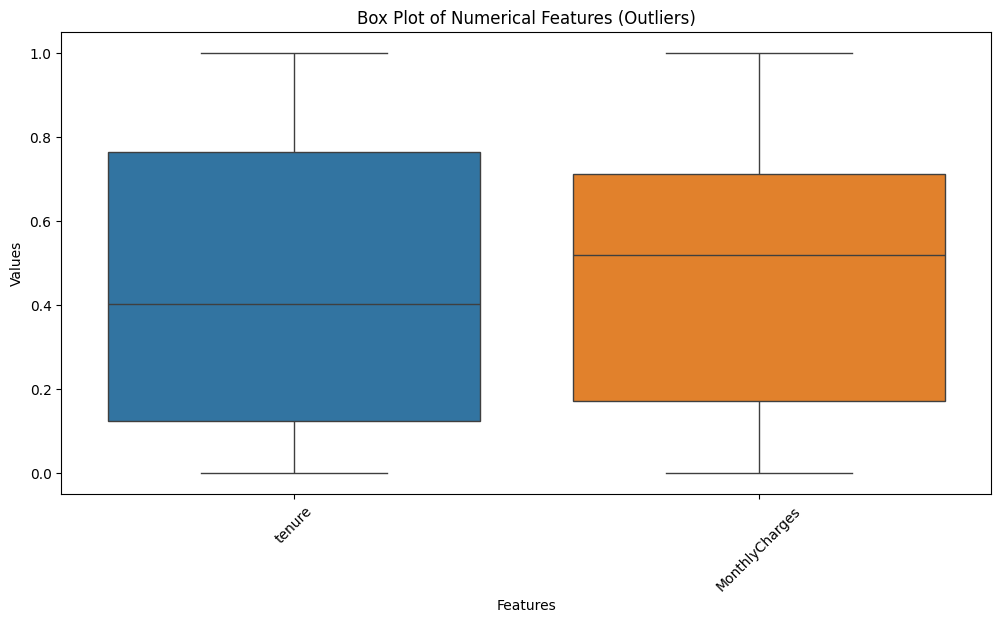

In [ ]:
# Identify numerical features
# Note: Using scaled data because without that the plots and visualization of outlier was unclear, for the documentation/visualisation purpose. However, the fixing of the data quality is done on original DataFrame
df_scaled = scaleDF(df)
num_features = df_scaled.select_dtypes(include=['float64', 'int']).columns.tolist()
# Combine all the outliers into a single DataFrame
combined_outliers = pd.concat([df_scaled[num_features[1:3]]], axis=1)

# Plot box plot of combined outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_outliers)
plt.title('Box Plot of Numerical Features (Outliers)')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

Insights of the Box plot:

*   Tenure: There are some outliers on the higher end, showing some customers have a significantly higher tenure.
*   MonthlyCharges and TotalCharges: The distribution is spread across a wide range, with some outliers, showing variance in the charges.






In [ ]:
# 3. Fixing Outliers
df = fixOutliers(df)

#### 4. Removing Duplicate Records

In [ ]:
# 4. Fixing Uniqueness
df = fixDuplicateRecords(df)

#### Data Quality Report (After Fixing the Data Quality Issues)
Note: NaN in the "Outlier Count" column is placed for non-numeric data.

In [ ]:
# completeness (percentage of missing values), consistency
# (validity of data formats and logical rules) and outliers.
data_quality_report = pd.concat([getDataCompleteness(df).set_index('Feature'),
    getDataConsistency(df).set_index('Feature'), getOutliers(df).set_index('Feature')],
                                axis=1)
data_quality_report

Missing Values (%)  Valid Values Count  Outlier Count
Feature                                                                
customerID                       0.0                7043            NaN
gender                           0.0                7043            NaN
SeniorCitizen                    0.0                7043            0.0
Partner                          0.0                7043            NaN
Dependents                       0.0                7043            NaN
tenure                           0.0                7043            0.0
PhoneService                     0.0                7043            NaN
MultipleLines                    0.0                7043            NaN
InternetService                  0.0                7043            NaN
OnlineSecurity                   0.0                7043            NaN
OnlineBackup                     0.0                7043            NaN
DeviceProtection                 0.0                7043            NaN
TechSupport                      0.0                7043            NaN
StreamingTV                      0.0                7043            NaN
StreamingMovies                  0.0                7043            NaN
Contract                         0.0                7043            NaN
PaperlessBilling                 0.0                7043            NaN
PaymentMethod                    0.0                7043            NaN
MonthlyCharges                   0.0                7043            0.0
TotalCharges                     0.0                7043            NaN
Churn                            0.0                7043            NaN

In [ ]:
# Uniqueness (identification of duplicate records)
print(getDataUniqueness(df).to_string(index=False))

 Total Records  Duplicate Records
          7043                  0


#### Data Preprocessing Steps

In [ ]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female            0.0     Yes         No     1.0           No   
1  5575-GNVDE    Male            0.0      No         No    34.0          Yes   
2  3668-QPYBK    Male            0.0      No         No     2.0          Yes   
3  7795-CFOCW    Male            0.0      No         No    45.0           No   
4  9237-HQITU  Female            0.0      No         No     2.0          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

#### 1. Data Manipulation:

In [ ]:
# Converting TotalCharges to numeric, forcing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
df.drop(columns=['customerID'], inplace = True)

#### 2. Feature Engineering (11 Features)

In [ ]:
# 1. Total Monthly Cost: Combining tenure and MonthlyCharges
df['TotalMonthlyCost'] = df['tenure'] * df['MonthlyCharges']

# 2. Charges Per Month: TotalCharges divided by tenure (adding 1 to tenure to avoid division by zero)
df['ChargesPerMonth'] = df['TotalCharges'] / (df['tenure'] + 1)

# 3. Number of Services: Counting the number of services the customer is subscribed to
df['NumServices'] = (df['PhoneService'] == 'Yes').astype(int) + \
                    (df['MultipleLines'] != 'No').astype(int) + \
                    (df['InternetService'] != 'No').astype(int) + \
                    (df['OnlineSecurity'] == 'Yes').astype(int) + \
                    (df['DeviceProtection'] == 'Yes').astype(int) + \
                    (df['TechSupport'] != 'No').astype(int) + \
                    (df['StreamingTV'] != 'No').astype(int) + \
                    (df['StreamingMovies'] != 'No').astype(int)

# 4. Has Dependents: Binary feature indicating if the customer has dependents
df['HasDependents'] = (df['Dependents'] == 'Yes').astype(int)

# 5. Is Senior Citizen: Binary feature indicating if the customer is a senior citizen
df['IsSeniorCitizen'] = (df['SeniorCitizen'] == 1).astype(int)

# 6. Uses Fiber Optic: Binary feature indicating if the customer uses fiber optic internet
df['UsesFiberOptic'] = (df['InternetService'] == 'Fiber optic').astype(int)

# 7. Has Multiple Lines: Binary feature indicating if the customer has multiple phone lines
df['HasMultipleLines'] = (df['MultipleLines'] != 'No').astype(int)

# 8. Is Month-to-Month Contract: Binary feature indicating if the customer has a month-to-month contract
df['IsMonthToMonthContract'] = (df['Contract'] == 'Month-to-month').astype(int)

# 9. Uses Electronic Payment: Binary feature indicating if the customer uses electronic payment method
df['UsesElectronicPayment'] = df['PaymentMethod'].str.contains('Electronic').astype(int)

# 10. Monthly Charges Ratio: Ratio of MonthlyCharges to TotalCharges
df['MonthlyChargesRatio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)

# 11. Service to Tenure Ratio: Ratio of the number of services to tenure
df['ServiceToTenureRatio'] = df['NumServices'] / (df['tenure'] + 1)

# 12. Streaming Services: Binary feature indicating if the customer uses both StreamingTV and StreamingMovies
df['StreamingServices'] = ((df['StreamingTV'] == 'Yes') & (df['StreamingMovies'] == 'Yes')).astype(int)

# 13. Support Services: Counting the number of support services the customer is subscribed to
df['SupportServices'] = ((df['OnlineSecurity'] == 'Yes').astype(int) + \
                         (df['DeviceProtection'] == 'Yes').astype(int) + \
                         (df['TechSupport'] == 'Yes').astype(int))

# 14. Tenure Group: Categorizing tenure into groups
def tenure_group(tenure):
    if tenure <= 12:
        return '0-1 year'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 48:
        return '2-4 years'
    elif tenure <= 60:
        return '4-5 years'
    else:
        return '5+ years'
df['TenureGroup'] = df['tenure'].apply(tenure_group)

# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'])

df.head()


SeniorCitizen  tenure OnlineBackup  MonthlyCharges  TotalCharges Churn  \
0            0.0     1.0          Yes           29.85         29.85    No   
1            0.0    34.0           No           56.95       1889.50    No   
2            0.0     2.0          Yes           53.85        108.15   Yes   
3            0.0    45.0           No           42.30       1840.75    No   
4            0.0     2.0           No           70.70        151.65   Yes   

   TotalMonthlyCost  ChargesPerMonth  NumServices  HasDependents  ...  \
0             29.85        14.925000            2              0  ...   
1           1936.30        53.985714            4              0  ...   
2            107.70        36.050000            3              0  ...   
3           1903.50        40.016304            5              0  ...   
4            141.40        50.550000            2              0  ...   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  \
0                False                     True              False   
1                False                    False               True   
2                False                     True              False   
3                False                    False               True   
4                False                     True              False   

   Contract_Two year  PaperlessBilling_No  PaperlessBilling_Yes  \
0              False                False                  True   
1              False                 True                 False   
2              False                False                  True   
3              False                 True                 False   
4              False                False                  True   

   PaymentMethod_Bank transfer (automatic)  \
0                                    False   
1                                    False   
2                                    False   
3                                     True   
4                                    False   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

  PaymentMethod_Mailed check  
0                      False  
1                       True  
2                       True  
3                      False  
4                      False  

[5 rows x 58 columns]

#### 3.  Anomalies Detection Using Isolation Forest

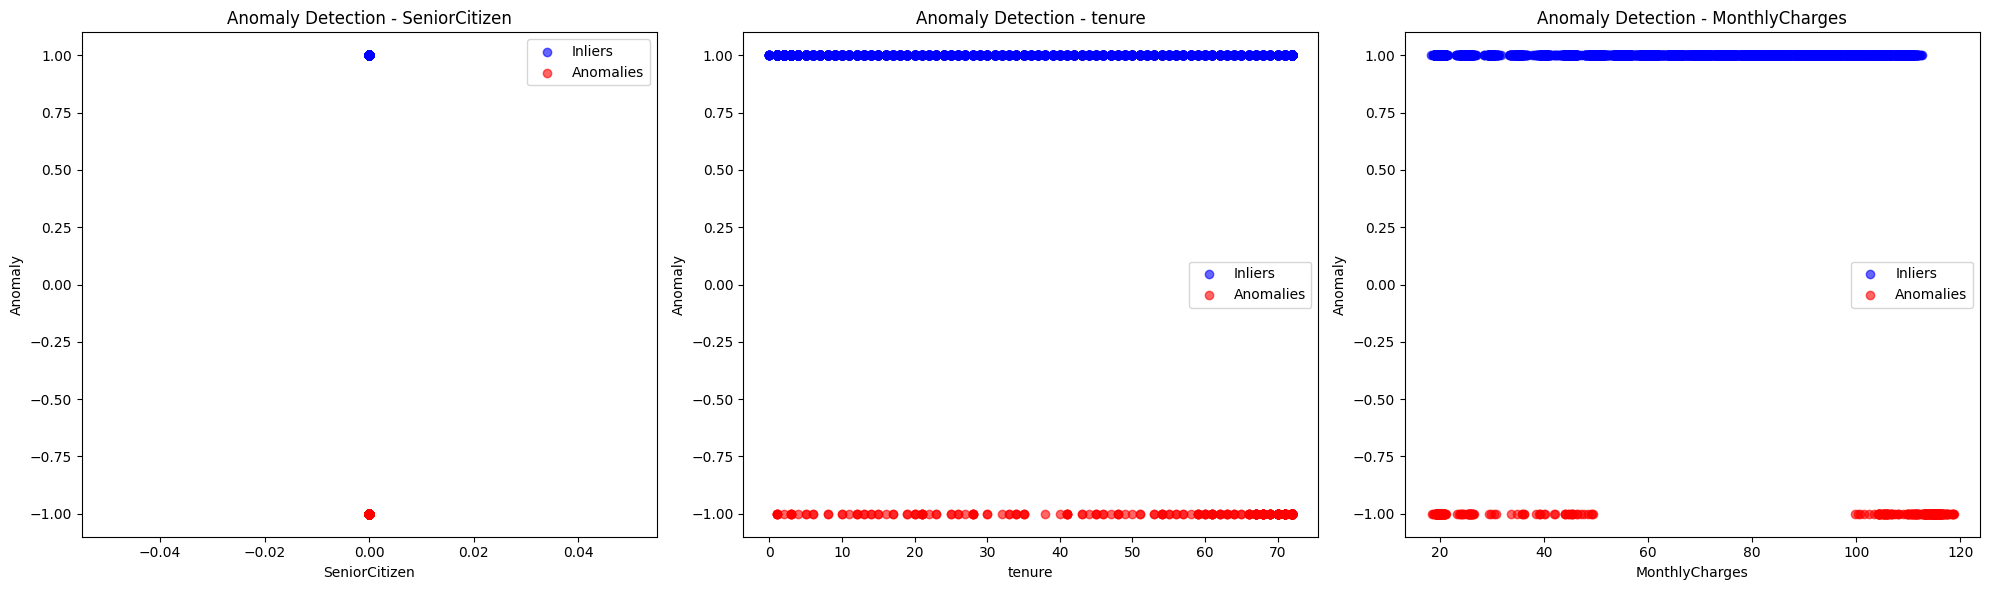

In [ ]:
isolation_forest = IsolationForest(contamination=0.05)

isolation_forest.fit(df[num_features])

# Predict anomalies
anomalies = isolation_forest.predict(df[num_features])

df['anomaly'] = anomalies

num_cols = 3
num_rows = (len(num_features) + num_cols - 1) // num_cols

# Plotting the results for each numerical feature
plt.figure(figsize=(20, 6 * num_rows))

for idx, feature in enumerate(num_features, start=1):
    plt.subplot(num_rows, num_cols, idx)

    plt.scatter(df[df['anomaly'] == 1][feature], df[df['anomaly'] == 1]['anomaly'],
                c='blue', label='Inliers', alpha=0.6)
    plt.scatter(df[df['anomaly'] == -1][feature], df[df['anomaly'] == -1]['anomaly'],
                c='red', label='Anomalies', alpha=0.6)

    plt.xlabel(feature)
    plt.ylabel('Anomaly')
    plt.title(f'Anomaly Detection - {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

Insights from the plot:
*   Tenure: If anomalies are found here, it might suggest customers with unusually short or long tenure compared to the majority.
*   MonthlyCharges: Anomalies might show customers with very high or very low charges that are atypical.
*   TotalCharges: High variance in total charges could reflect anomalies in customer spending patterns or billing issues.
*  NumServices: Anomalies could show customers with an unusually high or low number of services subscribed.



In [ ]:
# Remove anomalies from the dataset for further analysis
df = df[df['anomaly'] == 1].drop(columns=['anomaly'])

#### Data Quality Report (After Feature Engineering and Data Manipulation)
Note: NaN in the "Outlier Count" column is placed for non-numeric data.

#### 4. Scaling Numerical Features

In [ ]:
# Scaling the numerical features of the DataFrame
df_final = scaleDF(df)
df_unscaled = df

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'TotalMonthlyCost', 'ChargesPerMonth', 'NumServices', 'HasDependents', 'IsSeniorCitizen', 'UsesFiberOptic', 'HasMultipleLines', 'IsMonthToMonthContract', 'UsesElectronicPayment', 'MonthlyChargesRatio', 'ServiceToTenureRatio', 'StreamingServices', 'SupportServices']


In [ ]:
# Fixing Data Quality for both the scaled and unscaled dataframes

df_unscaled = fixMissingValues(df_unscaled)
df_unscaled = fixDataValidity(df_unscaled)
df_unscaled = fixOutliers(df_unscaled)
df_unscaled = fixDuplicateRecords(df_unscaled)

df_final = fixMissingValues(df_final)
df_final = fixDataValidity(df_final)
df_final = fixOutliers(df_final)
df_final = fixDuplicateRecords(df_final)

In [ ]:
# completeness (percentage of missing values), consistency
# (validity of data formats and logical rules) and outliers.
data_quality_report = pd.concat([getDataCompleteness(df_final).set_index('Feature'),
getDataConsistency(df_final).set_index('Feature'), getOutliers(df_final).set_index('Feature')],
                                axis=1)
data_quality_report

Missing Values (%)  Valid Values Count  Outlier Count
Feature                                                                      
OnlineBackup                           0.0                6603            NaN
Churn                                  0.0                6603            NaN
TenureGroup                            0.0                6603            NaN
SeniorCitizen                          0.0                6603            0.0
tenure                                 0.0                6603            0.0
MonthlyCharges                         0.0                6603            0.0
TotalCharges                           0.0                6603            0.0
TotalMonthlyCost                       0.0                6603            0.0
ChargesPerMonth                        0.0                6603            0.0
NumServices                            0.0                6603            0.0
HasDependents                          0.0                6603            0.0
IsSeniorCitizen                        0.0                6603            0.0
UsesFiberOptic                         0.0                6603            0.0
HasMultipleLines                       0.0                6603            0.0
IsMonthToMonthContract                 0.0                6603            0.0
UsesElectronicPayment                  0.0                6603            0.0
MonthlyChargesRatio                    0.0                6603            0.0
ServiceToTenureRatio                   0.0                6603            0.0
StreamingServices                      0.0                6603            0.0
SupportServices                        0.0                6603            0.0

In [ ]:
# Uniqueness (identification of duplicate records)
print(getDataUniqueness(df_final).to_string(index=False))

 Total Records  Duplicate Records
          6603                  0


#### II. Advanced Visualizations

#### 1. Visualizing Distributions of Numerical Features [Bar Chart]

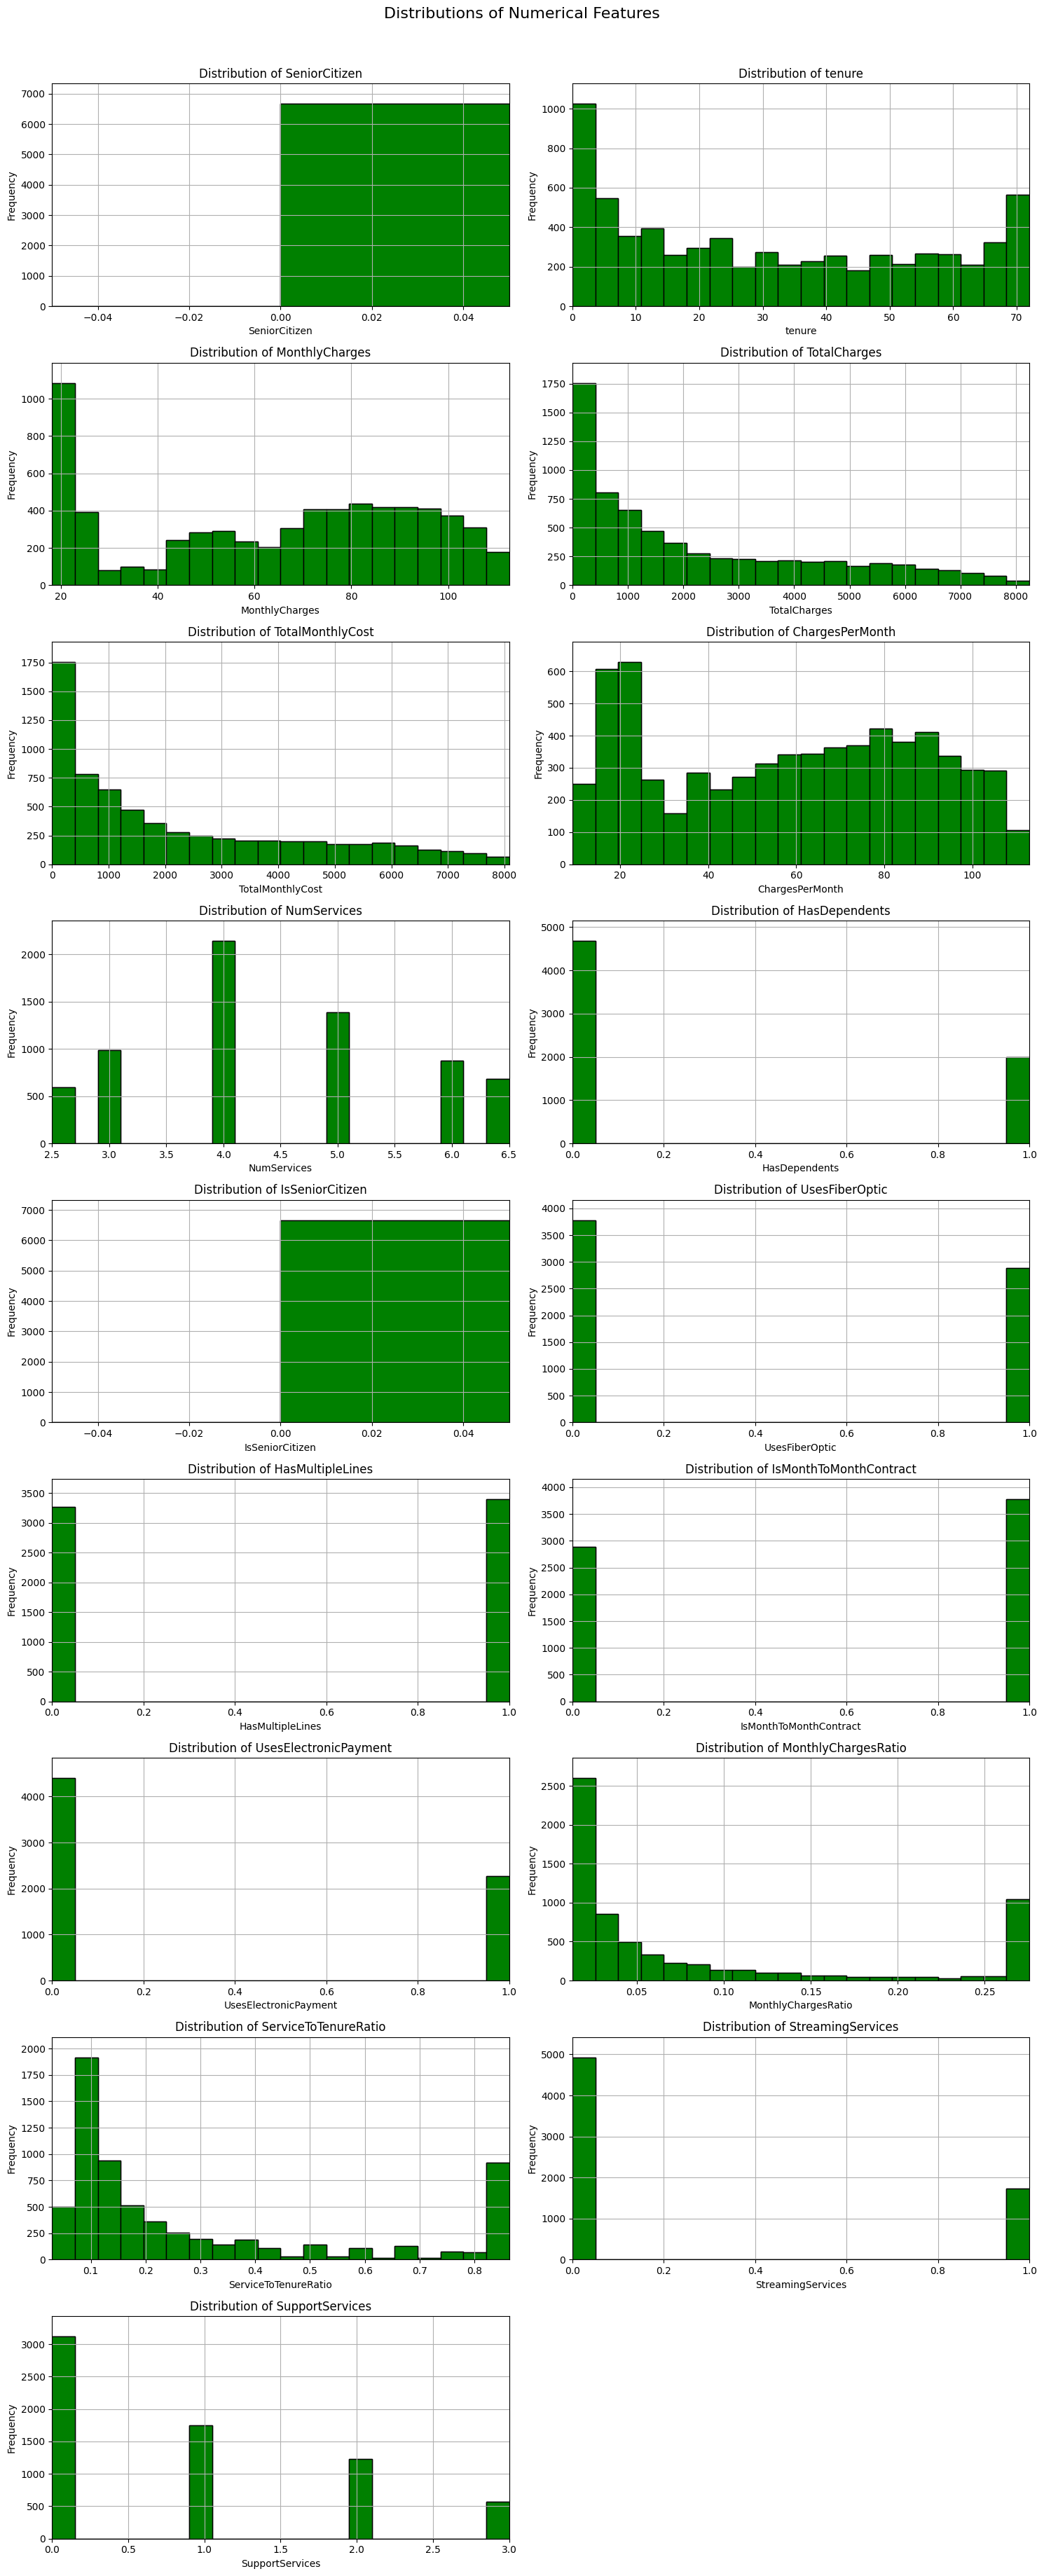

In [ ]:
numerical_features = df_unscaled.select_dtypes(include=['float64', 'int64'])
num_cols = 2
num_rows = (len(numerical_features.columns) + num_cols - 1) // num_cols

plt.figure(figsize=(15, num_rows * 4))

for i, column in enumerate(numerical_features.columns, 1):
    min_val = numerical_features[column].min()
    max_val = numerical_features[column].max()

    plt.subplot(num_rows, num_cols, i)
    plt.hist(numerical_features[column], bins=20, edgecolor='black', color='green')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.grid(True)

    plt.xlim(min_val, max_val)

    counts, _, _ = plt.hist(numerical_features[column], bins=20, edgecolor='black', color='green')
    y_max = counts.max() * 1.1
    plt.ylim(0, y_max)

plt.tight_layout()
plt.suptitle('Distributions of Numerical Features', y=1.02, fontsize=16)
plt.show()

Insights of the plot:
*   Skewness and Outliers: Most features show a right-skewed distribution with some high outliers. This suggests that while most customers fall within a lower range for tenure and charges, there are a few customers with significantly higher values.
*   Central Tendency and Spread: The histograms provide a clear view of the central tendency (mean or mode) and the spread of the data, which is useful for understanding the typical customer profile and identifying any extreme values.
*   Binary Features: For binary features like HasDependents and IsSeniorCitizen, the distribution is straightforward, indicating the proportion of each category in the dataset.

#### 2. Visualizing Distributions of Categorical Features [Count Plot]

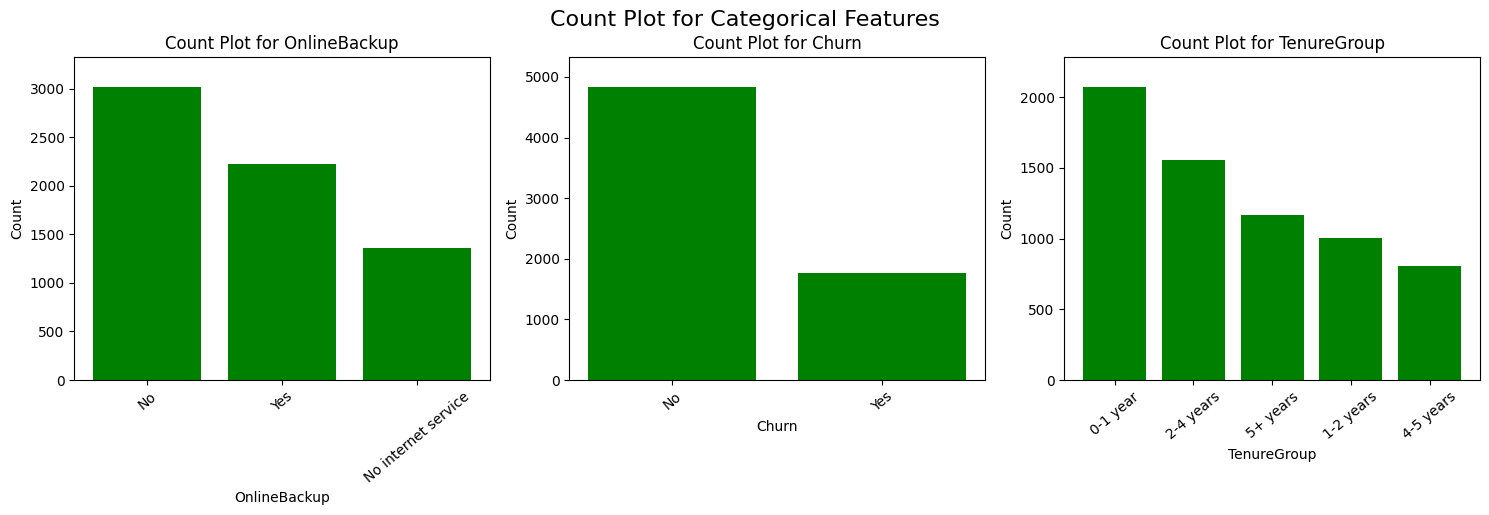

In [ ]:
cat_features = df_final.select_dtypes(include=['object'])

num_cols = 3
num_rows = (len(cat_features.columns) - 1) // num_cols + 1
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Flatten axes array if more than one subplot
if num_rows * num_cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, col in enumerate(cat_features.columns):
    counts = df_final[col].value_counts().nlargest(5)
    axes[i].bar(counts.index, counts.values, color='green')
    axes[i].set_title(f'Count Plot for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=40)
    axes[i].set_ylim(0, counts.max() + counts.max() * 0.1)  # Set y-axis limit for better visualization

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Count Plot for Categorical Features', y=1.02, fontsize=16)
plt.show()

Key points from visualization:
*   Service Adoption: Many customers do not use certain services like online backup, suggesting potential areas for increasing service adoption.
*   Customer Retention: The majority non-churn group shows stability, but the churn group indicates the need for targeted retention strategies.
*   New Customer Focus: A large number of new customers (0-1 year) suggest the importance of focusing on onboarding and early retention strategies.

#### 3. Visualizing Churn by Categorical Features [Violin Plot]

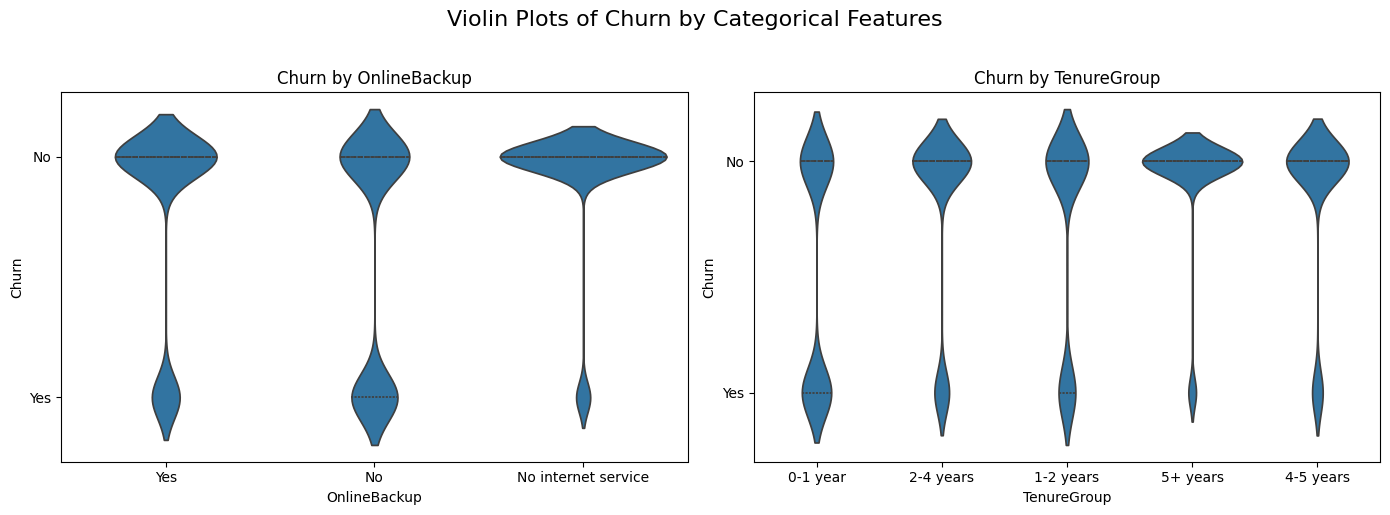

In [ ]:
categorical_features = ["OnlineBackup", "TenureGroup"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.violinplot(ax=axes[i], x=df_unscaled[feature], y=df_unscaled["Churn"], inner='quartile')
    axes[i].set_title(f"Churn by {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Churn")

plt.suptitle("Violin Plots of Churn by Categorical Features", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

Key points from the plot:
*   Service Adoption: Promoting online backup services may help reduce churn, as customers using this service show lower churn rates.
*   Customer Retention: Focus on retaining new customers (0-1 year) by improving their initial experience and addressing potential issues early in their tenure.

#### 4. Visualizing ____ by Categorical Features [Stacked Bar Chart]

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
# variables = ['Contract_Month-to-month']

# for i, variable in enumerate(variables):
#     aggregated_data = df_unscaled.groupby([variable, 'TenureGroup']).size().unstack(fill_value=0)

#     aggregated_data.plot(kind='bar', stacked=True, ax=axes[i])
#     axes[i].set_xlabel(variable)
#     axes[i].set_ylabel('Count')
#     axes[i].set_title(f'{variable} vs Popularity Rank')
#     axes[i].legend(title='Popularity Rank')

# plt.suptitle("Count of Vehicles by Categorical Features and Popularity Rank", fontsize=16, y=1.02)

# plt.tight_layout()
# plt.show()

#### 5. Visualizing Numerical Features (Outliers Fixed) [Box Plot]

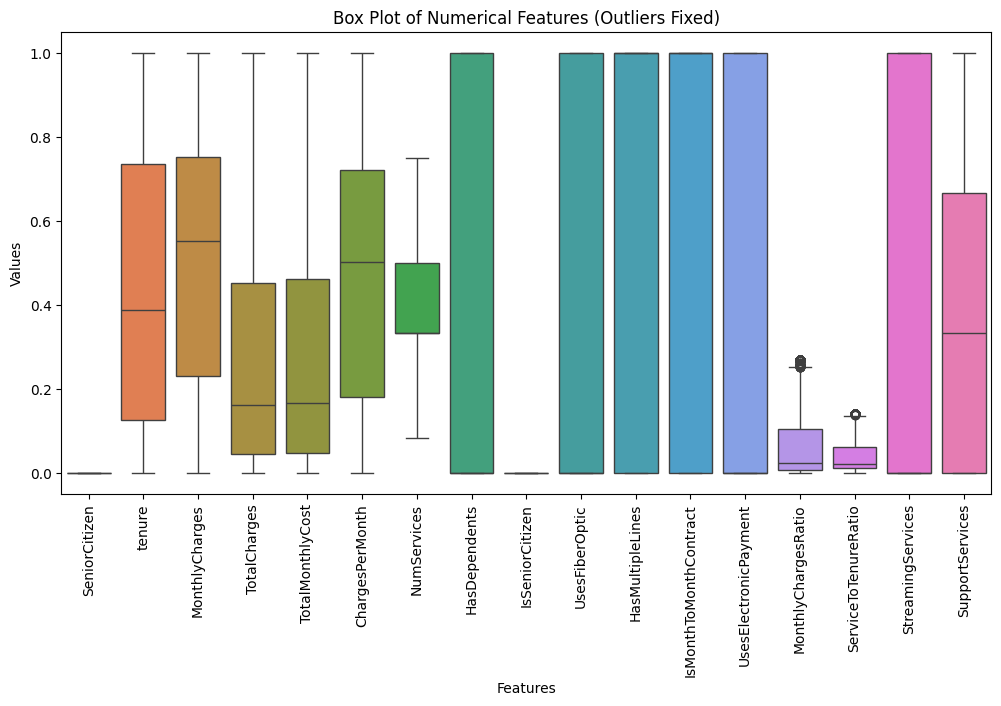

In [ ]:
num_features = df_final.select_dtypes(include=['float64', 'int']).columns.tolist()
combined_outliers = pd.concat([df_final[num_features]], axis=1)

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_outliers)
plt.title('Box Plot of Numerical Features (Outliers Fixed)')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.show()

Insights of the plot:
*   Each box plot represents the distribution of a numerical feature. The central box shows the interquartile range (IQR), which contains the middle 50% of the data.
*   The line inside the box represents the median of the features.
*   The "whiskers" extend to the smallest and largest values within 1.5 times the IQR from the lower and upper quartiles, respectively. Points outside this range are considered outliers.
*   For features such as TotalCharges and MonthlyCharges, you can see fewer outliers after fixing, indicating a more normalized distribution.
*   The IQR (box length) gives an idea of the variability or spread of the data. Larger boxes indicate higher variability in the feature values.
*   Features like TotalCharges and MonthlyCharges have higher variability compared to SeniorCitizen or NumServices.







#### 6. Visualizing Top 5 Correlated Feature Pairs [Box Plot]

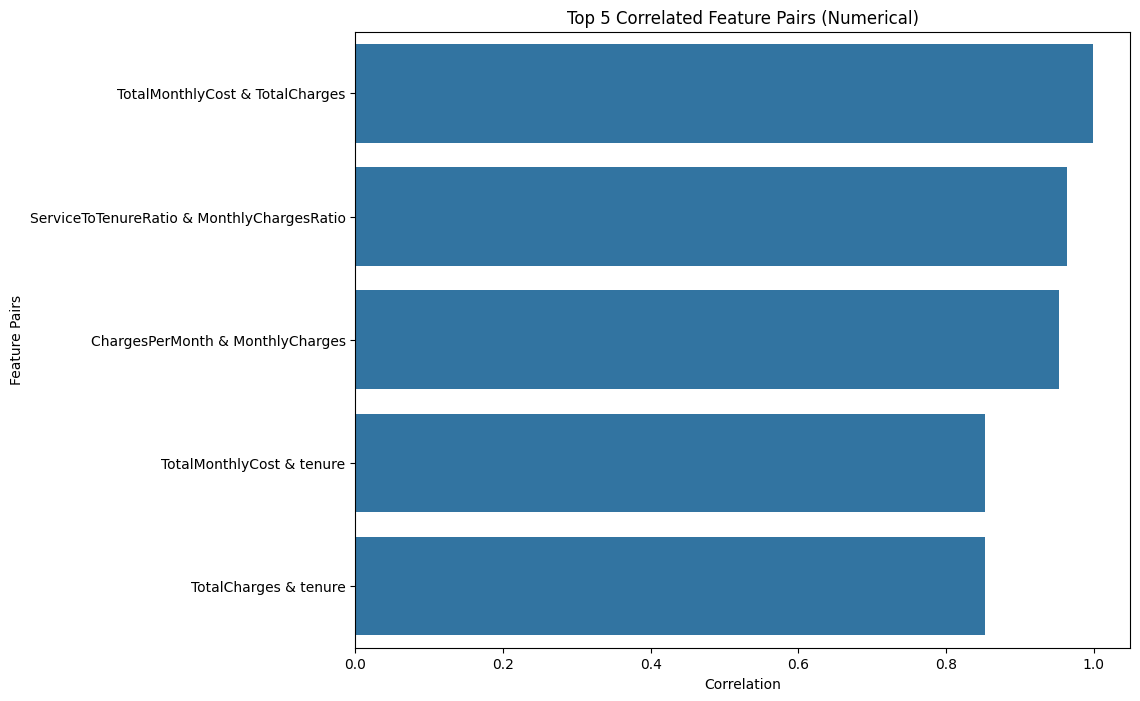

In [ ]:
# Calculate the correlation matrix
df_corr = df_unscaled[num_features].corr()

upper_triangle = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

abs_corr = upper_triangle.abs()
sorted_corr_pairs = abs_corr.unstack().sort_values(kind="quicksort", ascending=False)
top_corr_pairs = sorted_corr_pairs.head()

plt.figure(figsize=(10, 8))
plt.title("Top 5 Correlated Feature Pairs (Numerical)")
sns.barplot(x=top_corr_pairs.values, y=[f"{pair[0]} & {pair[1]}" for pair in top_corr_pairs.index])
plt.xlabel('Correlation')
plt.ylabel('Feature Pairs')
plt.show()

Insights from the plot:
*  High correlation between features can indicate multicollinearity, which may affect the performance of some machine learning models, particularly linear models. It's essential to handle multicollinearity to ensure model stability and interpretability.
*   Reducing redundancy by removing highly correlated features can improve model performance and interpretability.





#### 7. Visualizing Distribution of Highly Correlated Feature Pairs (Numerical) [KDE Plot]
**Note:** Implemented KDE plot instead of the scatter plot as it offers more insightful visualization compared to scatter plots, which can sometimes be misleading.

In [ ]:
# city_mpg = 'city mpg'
# highway_mpg = 'highway MPG'
# price_diff = 'Price Diff from Max MSRP'
# msrp = 'MSRP'
# engine_hp = 'Engine HP'

# fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# cmap = 'plasma'

# kde_plot1 = sns.kdeplot(x=df_final[city_mpg], y=df_final[highway_mpg], cmap=cmap, ax=axes[0])
# axes[0].set_title("KDE of City vs Highway MPG", fontsize=10)
# axes[0].set_xlabel(city_mpg)
# axes[0].set_ylabel(highway_mpg)
# if kde_plot1.collections:
#     cbar1 = plt.colorbar(kde_plot1.collections[0], ax=axes[0], orientation='vertical')
#     cbar1.set_label('Density')

# kde_plot2 = sns.kdeplot(x=df_final[engine_hp], y=df_final[msrp], cmap=cmap, ax=axes[1])
# axes[1].set_title("KDE Plot of Engine HP vs MSRP", fontsize=10)
# axes[1].set_xlabel(engine_hp)
# axes[1].set_ylabel(msrp)
# if kde_plot2.collections:
#     cbar2 = plt.colorbar(kde_plot2.collections[0], ax=axes[1], orientation='vertical')
#     cbar2.set_label('Density')

# plt.tight_layout()
# plt.suptitle("Distribution of Highly Correlated Feature Pairs (Numerical)", fontsize=18, y=1.04)
# plt.show()

#### 8. Visualizing Correlation Between the Features [Heatmap]

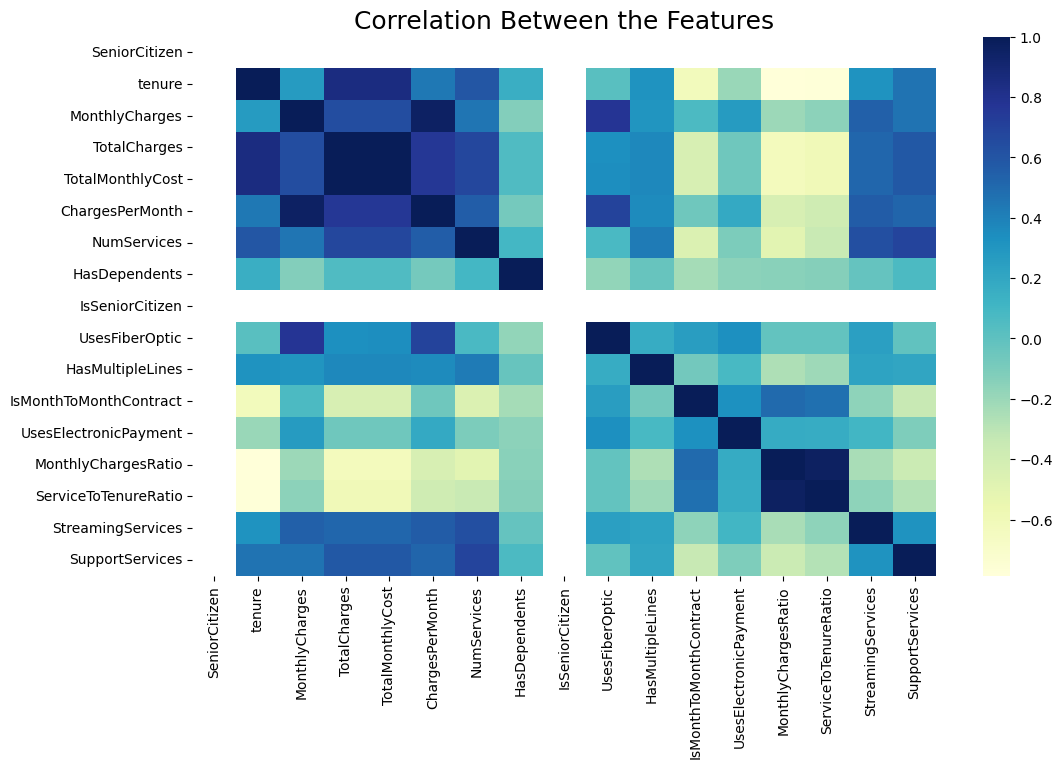

In [ ]:
df_corr=df_final[num_features].corr()
f,ax=plt.subplots(figsize=(12,7))
sns.heatmap(df_corr, cmap='YlGnBu')
plt.title("Correlation Between the Features",fontsize=18)
plt.show()

Insights from the plot:
*   The color gradient from the heatmap provides a quick visual cue to identify the strength and direction of correlations. Darker shades represent stronger positive correlations, while lighter shades represent weaker or negative correlations.
*   TotalCharges & MonthlyCharges: This pair shows a strong positive correlation. Since TotalCharges is collected from MonthlyCharges, this high correlation is expected.
*   Tenure & TotalCharges: There is a significant positive correlation between Tenure and TotalCharges, indicating that customers with longer tenure tend to have higher total charges due to longer service usage.








#### III.  Statistical Summaries

#### Utility Functions for Summary Statistics

In [ ]:
def getNumStatistics(df:pd.DataFrame):
    numeric_describe = df.describe(include=['number']).T
    unique_counts_df = pd.DataFrame(df.select_dtypes(include='number').nunique(),
                                columns=['Cardinality']).reset_index()
    unique_counts_df.columns = ['Feature', 'Cardinality']

    # Rename columns to capitalize
    numeric_describe.columns = map(str.capitalize, numeric_describe.columns)

    data_quality_report = pd.concat([numeric_describe,
                        unique_counts_df.set_index('Feature')], axis=1)
    return data_quality_report

In [ ]:
def getCatStatistics(df: pd.DataFrame):
    # Get describe for non-numeric columns and capitalize headers
    numeric_describe = df.describe(exclude=['number']).T
    numeric_describe.columns = map(str.capitalize, numeric_describe.columns)

    # Select non-numeric columns
    cat_df = df.select_dtypes(exclude='number')

    # Calculate mode and its frequency
    mode_df = pd.DataFrame(cat_df.apply(
        lambda x: x.mode().iloc[0] if not x.mode().empty else None),
                           columns=['Mode'])
    mode_percent_df = pd.DataFrame(cat_df.apply(
        lambda x: (x.value_counts().iloc[0] / len(x)) * 100 if not x.mode().empty else 0),
                                   columns=['Mode %'])

    # Calculate second mode and its frequency
    second_mode_df = pd.DataFrame(cat_df.apply(
        lambda x: x[~x.isin([x.mode().iloc[0]])].mode().iloc[0]
        if len(x[~x.isin([x.mode().iloc[0]])].mode()) > 0 else None), columns=['2nd Mode'])
    second_mode_freq_df = pd.DataFrame(cat_df.apply(
        lambda x: x[~x.isin([x.mode().iloc[0]])].value_counts().iloc[0]
                                                    if len(x[~x.isin([x.mode().iloc[0]])].mode()) > 0 else 0),
                                       columns=['2nd Mode Freq'])
    second_mode_percent_df = pd.DataFrame(cat_df.apply(
        lambda x: (x[~x.isin([x.mode().iloc[0]])].value_counts().iloc[0] / len(x)) * 100
        if len(x[~x.isin([x.mode().iloc[0]])].mode()) > 0 else 0), columns=['2nd Mode %'])

    # Calculate missing values percentage and valid values count
    missing_values_percentage_df = pd.DataFrame(cat_df.isna().mean() * 100, columns=['Missing Values (%)'])
    valid_values_count_df = pd.DataFrame(cat_df.notna().sum(), columns=['Valid Values Count'])

    # Get unique counts for non-numeric columns
    unique_counts_df = pd.DataFrame(cat_df.nunique(), columns=['Cardinality']).reset_index()
    unique_counts_df.columns = ['Feature', 'Cardinality']
    unique_counts_df.set_index('Feature', inplace=True)

    # Combine all reports
    data_quality_report = pd.concat([
        numeric_describe,
        mode_df,
        mode_percent_df,
        second_mode_df,
        second_mode_freq_df,
        second_mode_percent_df,
        unique_counts_df
    ], axis=1)

    return data_quality_report

#### 1. Statistics for Continuous Features

Continuous Features Statistics includes:
1. Count of Total Instances
2. Mean
3. Standard deviation
4. Min
5. 1st quartile
6. 2nd quartile - Median
7. 3rd quartile
8. Max
9. Cardinality - No. of distinct values for a feature

In [ ]:
# Numerical Feature Summary Statistics
getNumStatistics(df_unscaled)

Count         Mean          Std        Min  \
SeniorCitizen           6666.0     0.000000     0.000000   0.000000   
tenure                  6666.0    31.181368    23.988825   0.000000   
MonthlyCharges          6666.0    64.285756    29.114860  18.250000   
TotalCharges            6666.0  2199.016382  2191.977331   0.000000   
TotalMonthlyCost        6666.0  2198.969127  2190.256316   0.000000   
ChargesPerMonth         6666.0    58.522246    29.562134   9.183333   
NumServices             6666.0     4.444419     1.233665   2.500000   
HasDependents           6666.0     0.297930     0.457383   0.000000   
IsSeniorCitizen         6666.0     0.000000     0.000000   0.000000   
UsesFiberOptic          6666.0     0.432793     0.495500   0.000000   
HasMultipleLines        6666.0     0.510201     0.499933   0.000000   
IsMonthToMonthContract  6666.0     0.566607     0.495581   0.000000   
UsesElectronicPayment   6666.0     0.340234     0.473823   0.000000   
MonthlyChargesRatio     6666.0     0.086929     0.094974   0.012952   
ServiceToTenureRatio    6666.0     0.295226     0.277947   0.029412   
StreamingServices       6666.0     0.260426     0.438900   0.000000   
SupportServices         6666.0     0.887489     0.991760   0.000000   

                               25%          50%          75%          Max  \
SeniorCitizen             0.000000     0.000000     0.000000     0.000000   
tenure                    8.000000    27.000000    53.000000    72.000000   
MonthlyCharges           38.925000    70.275000    89.150000   112.550000   
TotalCharges            370.425000  1316.125000  3690.550000  8240.850000   
TotalMonthlyCost        367.087500  1316.700000  3694.100000  8082.000000   
ChargesPerMonth          27.156250    60.810779    83.714844   112.888356   
NumServices               4.000000     4.000000     5.000000     6.500000   
HasDependents             0.000000     0.000000     1.000000     1.000000   
IsSeniorCitizen           0.000000     0.000000     0.000000     0.000000   
UsesFiberOptic            0.000000     0.000000     1.000000     1.000000   
HasMultipleLines          0.000000     1.000000     1.000000     1.000000   
IsMonthToMonthContract    0.000000     1.000000     1.000000     1.000000   
UsesElectronicPayment     0.000000     0.000000     1.000000     1.000000   
MonthlyChargesRatio       0.018885     0.036830     0.120066     0.275671   
ServiceToTenureRatio      0.096154     0.153846     0.400000     0.863122   
StreamingServices         0.000000     0.000000     1.000000     1.000000   
SupportServices           0.000000     1.000000     2.000000     3.000000   

                        Cardinality  
SeniorCitizen                     1  
tenure                           73  
MonthlyCharges                 1487  
TotalCharges                   6194  
TotalMonthlyCost               5750  
ChargesPerMonth                6304  
NumServices                       6  
HasDependents                     2  
IsSeniorCitizen                   1  
UsesFiberOptic                    2  
HasMultipleLines                  2  
IsMonthToMonthContract            2  
UsesElectronicPayment             2  
MonthlyChargesRatio            5625  
ServiceToTenureRatio            285  
StreamingServices                 2  
SupportServices                   4

#### 2. Statistics for Categorical Features

Categorical Features Statistics includes:
1. Count of Total Instances
2. Count of Unique Instances
3. Top - Most Frequent Value
4. Frequency of mode
5. Mode - the most frequent value
6. Proportion of mode in the dataset
7. 2nd mode - the second most frequent value
8. Frequency of 2nd mode
9. Proportion of 2nd mode in the dataset
10. Cardinality - No. of distinct values for a feature

In [ ]:
# Categorical Feature Summary Statistics
getCatStatistics(df_unscaled)

Count Unique       Top  Freq  \
OnlineBackup                             6666      3        No  3041   
Churn                                    6666      2        No  4870   
TenureGroup                              6666      5  0-1 year  2136   
gender_Female                            6666      2     False  3365   
gender_Male                              6666      2      True  3365   
Partner_No                               6666      2      True  3491   
Partner_Yes                              6666      2     False  3491   
Dependents_No                            6666      2      True  4680   
Dependents_Yes                           6666      2     False  4680   
PhoneService_No                          6666      2     False  6021   
PhoneService_Yes                         6666      2      True  6021   
MultipleLines_No                         6666      2     False  3401   
MultipleLines_No phone service           6666      2     False  6021   
MultipleLines_Yes                        6666      2     False  3910   
InternetService_DSL                      6666      2     False  4285   
InternetService_Fiber optic              6666      2     False  3781   
InternetService_No                       6666      2     False  5266   
OnlineSecurity_No                        6666      2      True  3418   
OnlineSecurity_No internet service       6666      2     False  5266   
OnlineSecurity_Yes                       6666      2     False  4818   
DeviceProtection_No                      6666      2     False  3606   
DeviceProtection_No internet service     6666      2     False  5266   
DeviceProtection_Yes                     6666      2     False  4460   
TechSupport_No                           6666      2      True  3404   
TechSupport_No internet service          6666      2     False  5266   
TechSupport_Yes                          6666      2     False  4804   
StreamingTV_No                           6666      2     False  3896   
StreamingTV_No internet service          6666      2     False  5266   
StreamingTV_Yes                          6666      2     False  4170   
StreamingMovies_No                       6666      2     False  3921   
StreamingMovies_No internet service      6666      2     False  5266   
StreamingMovies_Yes                      6666      2     False  4145   
Contract_Month-to-month                  6666      2      True  3777   
Contract_One year                        6666      2     False  5251   
Contract_Two year                        6666      2     False  5192   
PaperlessBilling_No                      6666      2     False  3952   
PaperlessBilling_Yes                     6666      2      True  3952   
PaymentMethod_Bank transfer (automatic)  6666      2     False  5237   
PaymentMethod_Credit card (automatic)    6666      2     False  5247   
PaymentMethod_Electronic check           6666      2     False  4398   
PaymentMethod_Mailed check               6666      2     False  5116   

                                             Mode     Mode %   2nd Mode  \
OnlineBackup                                   No  45.619562        Yes   
Churn                                          No  73.057306        Yes   
TenureGroup                              0-1 year  32.043204  2-4 years   
gender_Female                               False  50.480048       True   
gender_Male                                  True  50.480048      False   
Partner_No                                   True  52.370237      False   
Partner_Yes                                 False  52.370237       True   
Dependents_No                                True  70.207021      False   
Dependents_Yes                              False  70.207021       True   
PhoneService_No                             False  90.324032       True   
PhoneService_Yes                             True  90.324032      False   
MultipleLines_No                            False  51.020102       True   
MultipleLines_No phone service          

#### Encoding Categorical Features Using Label Encoding

In [ ]:
# Identify categorical features
cat_features = ['OnlineBackup', 'Churn', 'TenureGroup']

# Create a copy of the DataFrame to apply Label Encoding
label_encoded_df = df_final.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical feature
for feature in cat_features:
    label_encoded_df[feature] = label_encoder.fit_transform(label_encoded_df[feature])

# Concatenate the label encoded features with the rest of the DataFrame
df_scaled_label_encoded = pd.concat([df_final.drop(columns=cat_features).reset_index(drop=True),
                                     label_encoded_df[cat_features].reset_index(drop=True)], axis=1)

In [ ]:
display(HTML('<h2 style="text-align: center;">Label Encoded DataFrame</h2>'))
df_scaled_label_encoded.head()

SeniorCitizen    tenure  MonthlyCharges  TotalCharges  TotalMonthlyCost  \
0            0.0  0.013889        0.123012      0.001344          0.003693   
1            0.0  0.472222        0.410392      0.227522          0.239582   
2            0.0  0.027778        0.377519      0.010867          0.013326   
3            0.0  0.625000        0.255037      0.221593          0.235523   
4            0.0  0.027778        0.556204      0.016158          0.017496   

   ChargesPerMonth  NumServices  HasDependents  IsSeniorCitizen  \
0         0.055365     0.083333            0.0              0.0   
1         0.432017     0.333333            0.0              0.0   
2         0.259068     0.166667            0.0              0.0   
3         0.297314     0.500000            0.0              0.0   
4         0.398888     0.083333            0.0              0.0   

   UsesFiberOptic  HasMultipleLines  IsMonthToMonthContract  \
0             0.0               1.0                     1.0   
1             0.0               0.0                     0.0   
2             0.0               0.0                     1.0   
3             0.0               1.0                     0.0   
4             1.0               0.0                     1.0   

   UsesElectronicPayment  MonthlyChargesRatio  ServiceToTenureRatio  \
0                    1.0             0.268980              0.139636   
1                    0.0             0.017582              0.014215   
2                    0.0             0.268980              0.139636   
3                    0.0             0.010254              0.013279   
4                    1.0             0.268980              0.106732   

   StreamingServices  SupportServices  OnlineBackup  Churn  TenureGroup  
0                0.0         0.000000             2      0            0  
1                0.0         0.666667             0      0            2  
2                0.0         0.333333             2      1            0  
3                0.0         1.000000             0      0            2  
4                0.0         0.000000             0      1            0

In [ ]:
df_final = df_scaled_label_encoded

In [ ]:
df_final.shape

(6603, 20)

In [ ]:
# # Replace null values in the TotalCharges column with 0 and convert them to floating point numbers
# data['TotalCharges'] = data['TotalCharges'].replace(' ', 0).astype(float)

# # Calculate median of numeric columns only
# numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
# data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# # Confirmation of correct data type conversion
# print(data.dtypes)


In [ ]:
# from sklearn.preprocessing import LabelEncoder

# # Coding of dichotomous variables
# binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
# label_encoders = {}
# for column in binary_columns:
#     label_encoders[column] = LabelEncoder()
#     data[column] = label_encoders[column].fit_transform(data[column])

# # Unique heat coding for multicategorical variables
# data = pd.get_dummies(data, columns=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
#                                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
#                                      'Contract', 'PaymentMethod'], drop_first=True)

# # View encoded data
# print(data.head())
# print(data.info())

#### Predictor Variable Distribution

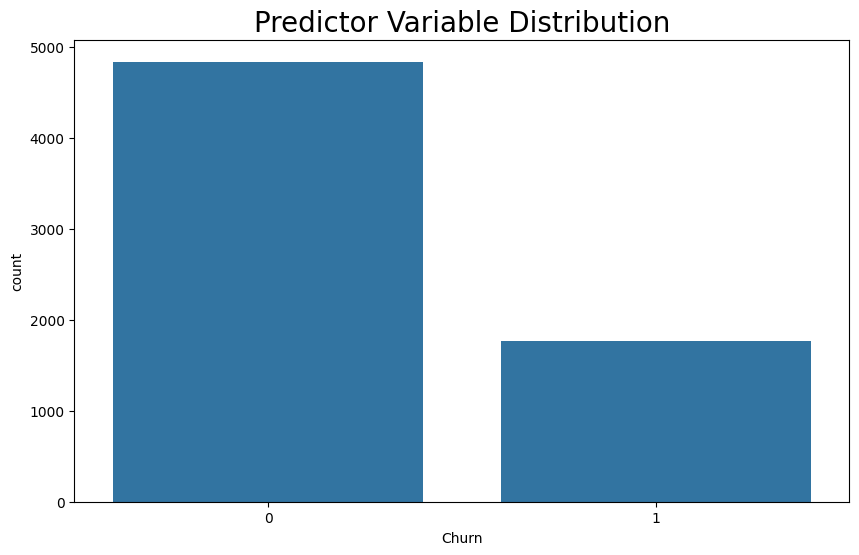

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x="Churn")
plt.title("Predictor Variable Distribution", fontsize=20)
plt.show()

Key points from the plot:
*   Since churn affects a smaller group, targeted efforts can be made to understand and address the reasons for churn.
*   Proper techniques should be applied to handle the class imbalance in predictive modeling to ensure accurate and fair predictions



#### Imbalance Mitigation Techniques

In [ ]:
# Identify categorical features based on object data type
cat_features = df_final.select_dtypes(include=['object']).columns.tolist()

# Create a copy of the DataFrame to apply Label Encoding
label_encoded_df = df_final.copy()

# Initialize LabelEncoder for each categorical feature
label_encoders = {feature: LabelEncoder() for feature in cat_features}

# Apply LabelEncoder to each categorical feature
for feature in cat_features:
    label_encoded_df[feature] = label_encoders[feature].fit_transform(label_encoded_df[feature])

# Separate the features and target variable
X = label_encoded_df.drop(columns=['Churn'])
y = label_encoded_df['Churn']

# Combine the features and target into one DataFrame for resampling
df_combined = pd.concat([X, y], axis=1)

In [ ]:
# Separate the majority and minority classes
df_majority = df_combined[df_combined.Churn == 0]
df_minority = df_combined[df_combined.Churn == 1]

# Upsample the minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples=len(df_majority), # to match majority class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Separate back into features and target
X_upsampled = df_upsampled.drop(columns=['Churn'])
y_upsampled = df_upsampled['Churn']

# Combine X_upsampled and y_upsampled into a single DataFrame
df_final_upsampled = pd.concat([X_upsampled, y_upsampled], axis=1)

# Reverse the Label Encoding
for feature in cat_features:
    if feature != 'Churn':  # We don't reverse 'Churn' as it is our target variable
        df_final_upsampled[feature] = label_encoders[feature].inverse_transform(df_final_upsampled[feature])

# Print the shape of the new DataFrame and the class distribution
print("Shape of df_final_upsampled:", df_final_upsampled.shape)
print("Class distribution in df_final_upsampled:\n", df_final_upsampled['Churn'].value_counts())

# # If you need to reverse the encoding for 'Churn' as well (optional)
# df_final_upsampled['Churn'] = label_encoders['Churn'].inverse_transform(df_final_upsampled['Churn'])

df = df_final_upsampled

Shape of df_final_upsampled: (9678, 20)
Class distribution in df_final_upsampled:
 Churn
0    4839
1    4839
Name: count, dtype: int64


#### Extracting Correlated Features

In [ ]:
# Step 1: Identify Correlated Features
corr_matrix = df_final.corr().abs()

# Selecting upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Finding features with correlation greater than 0.9
threshold = 0.9
highly_correlated_features = [column for column in upper.columns if any(upper[column] > threshold)]

print("Highly Correlated Features (Threshold > 0.9):", highly_correlated_features)

Highly Correlated Features (Threshold > 0.9): ['TotalMonthlyCost', 'ChargesPerMonth', 'ServiceToTenureRatio', 'TenureGroup']


In [ ]:
# Step 2: Calculate VIF
df_final = df_final.drop(columns=highly_correlated_features)
df_final = add_constant(df_final)  # Adding a constant column to the DataFrame

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_final.values, i) for i in range(df_final.shape[1])]
vif["features"] = df_final.columns

vif

VIF Factor                features
0    36.295745                   const
1          NaN           SeniorCitizen
2    10.743256                  tenure
3    10.052618          MonthlyCharges
4    12.301549            TotalCharges
5     4.358245             NumServices
6     1.084403           HasDependents
7          NaN         IsSeniorCitizen
8     5.212116          UsesFiberOptic
9     1.438884        HasMultipleLines
10    2.149651  IsMonthToMonthContract
11    1.284955   UsesElectronicPayment
12    2.834814     MonthlyChargesRatio
13    2.676725       StreamingServices
14    3.682901         SupportServices
15    1.250513            OnlineBackup
16    1.408902                   Churn

In [ ]:
# Step 3: Handle Correlated Features
# Remove features with high VIF (> 10)
features_to_remove = vif[vif["VIF Factor"] > 10]["features"].tolist()
if 'const' in features_to_remove:
    features_to_remove.remove('const')  # Do not remove the constant

df_final = df_final.drop(columns=features_to_remove)

df_final.head()

const  SeniorCitizen  NumServices  HasDependents  IsSeniorCitizen  \
0    1.0            0.0     0.083333            0.0              0.0   
1    1.0            0.0     0.333333            0.0              0.0   
2    1.0            0.0     0.166667            0.0              0.0   
3    1.0            0.0     0.500000            0.0              0.0   
4    1.0            0.0     0.083333            0.0              0.0   

   UsesFiberOptic  HasMultipleLines  IsMonthToMonthContract  \
0             0.0               1.0                     1.0   
1             0.0               0.0                     0.0   
2             0.0               0.0                     1.0   
3             0.0               1.0                     0.0   
4             1.0               0.0                     1.0   

   UsesElectronicPayment  MonthlyChargesRatio  StreamingServices  \
0                    1.0             0.268980                0.0   
1                    0.0             0.017582                0.0   
2                    0.0             0.268980                0.0   
3                    0.0             0.010254                0.0   
4                    1.0             0.268980                0.0   

   SupportServices  OnlineBackup  Churn  
0         0.000000             2      0  
1         0.666667             0      0  
2         0.333333             2      1  
3         1.000000             0      0  
4         0.000000             0      1

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   const                   6603 non-null   float64
 1   SeniorCitizen           6603 non-null   float64
 2   NumServices             6603 non-null   float64
 3   HasDependents           6603 non-null   float64
 4   IsSeniorCitizen         6603 non-null   float64
 5   UsesFiberOptic          6603 non-null   float64
 6   HasMultipleLines        6603 non-null   float64
 7   IsMonthToMonthContract  6603 non-null   float64
 8   UsesElectronicPayment   6603 non-null   float64
 9   MonthlyChargesRatio     6603 non-null   float64
 10  StreamingServices       6603 non-null   float64
 11  SupportServices         6603 non-null   float64
 12  OnlineBackup            6603 non-null   int64  
 13  Churn                   6603 non-null   int64  
dtypes: float64(12), int64(2)
memory usage: 7

#### Dimentionality Reduction

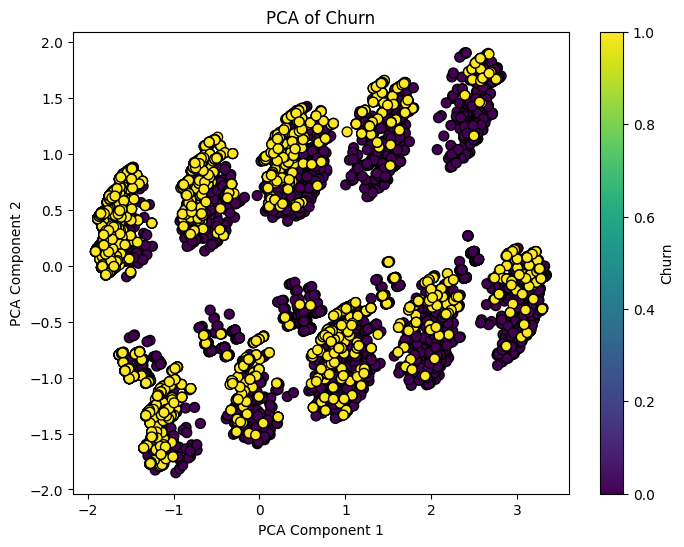

In [ ]:
# Apply PCA
n_components = 2
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_upsampled)

# Plot PCA results
plt.figure(figsize=(8, 6))

if X_pca.shape[1] == 1:
    plt.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]), c=y_upsampled, cmap='viridis', edgecolor='k', s=50)
    plt.xlabel('PCA Component 1')
    plt.ylabel('')
else:
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_upsampled, cmap='viridis', edgecolor='k', s=50)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

plt.title('PCA of Churn')
plt.colorbar(label='Churn')
plt.show()


Key points from the plot:
*   PCA has effectively reduced the data to two dimensions, simplifying the visualization and interpretation of complex, high-dimensional data.
*   The plot helps in understanding the distribution and separation of churned vs. non-churned customers. If the two groups are well-separated, it suggests that PCA has effectively identified the features that differentiate churned customers.
*   Identifying clusters can help in understanding different customer segments and tailoring strategies for each segment.






#### Modelling

In [ ]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_upsampled, test_size=0.2, random_state=42, stratify=y_upsampled)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7742, 2)
X_test shape: (1936, 2)
y_train shape: (7742,)
y_test shape: (1936,)


#### Random Search - Random Forest, Adaboost, Logistic Regression, SVM, KNN, Decision Tree, Gradient Boosting

In [ ]:
# Define parameter grids
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

ab_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1.0]
}

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

xgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Randomized search for Random Forest model
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
rf_random_search.fit(X_train, y_train)
best_rf_model = rf_random_search.best_estimator_

# Randomized search for Adaboost model
ab_random_search = RandomizedSearchCV(
    estimator=AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    param_distributions=ab_param_grid,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
ab_random_search.fit(X_train, y_train)
best_ab_model = ab_random_search.best_estimator_

# Randomized search for Logistic Regression model
lr_random_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=lr_param_grid,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
lr_random_search.fit(X_train, y_train)
best_lr_model = lr_random_search.best_estimator_

# Randomized search for SVM model
svm_random_search = RandomizedSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_distributions=svm_param_grid,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
svm_random_search.fit(X_train, y_train)
best_svm_model = svm_random_search.best_estimator_

# Randomized search for KNN model
knn_random_search = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=knn_param_grid,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
knn_random_search.fit(X_train, y_train)
best_knn_model = knn_random_search.best_estimator_

# Randomized search for Decision Tree model
dt_random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=dt_param_grid,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
dt_random_search.fit(X_train, y_train)
best_dt_model = dt_random_search.best_estimator_

# Randomized search for Gradient Boosting model
gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=gb_param_grid,
    n_iter=10,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
gb_random_search.fit(X_train, y_train)
best_gb_model = gb_random_search.best_estimator_

# Randomized search for XGBoost model
xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
xgb_random_search.fit(X_train, y_train)
best_xgb_model = xgb_random_search.best_estimator_

# Naive Bayes model (no hyperparameters to tune)
best_nb_model = GaussianNB()
best_nb_model = best_nb_model.fit(X_train, y_train)

# Train the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_rf_model),
        ('ab', best_ab_model),
        ('lr', best_lr_model),
        ('svm', best_svm_model),
        ('knn', best_knn_model),
        ('dt', best_dt_model),
        ('gb', best_gb_model),
        ('nb', best_nb_model)
    ],
    final_estimator=LogisticRegression()
)

stacking_model = stacking_clf.fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 2 folds for each of 20 candidates, totalling 40 fits


In [ ]:
stacking_model

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=20,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('ab',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   n_estimators=100,
                                                   random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.01, max_iter=1000,
                                                   random_state=42,
                                                   solver='saga')),
                               ('svm',
                                SVC(C=10, gamma='auto', probability=True,
                                    random_state=42)),
                               ('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=9,
                                                     weights='distance')),
                               ('dt',
                                DecisionTreeClassifier(max_depth=30,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(max_depth=7,
                                                           n_estimators=150,
                                                           random_state=42)),
                               ('nb', GaussianNB())],
                   final_estimator=LogisticRegression())

#### Model Evaluation with Cost

In [ ]:
# Cost matrix
cost_matrix = np.array([[0, 25], [100, 0]])

# Function to evaluate model performance considering cost matrix
def evaluate_classification_model_with_cost(model, X_test, y_test, cost_matrix):
    y_pred = model.predict(X_test)

    # For probability-based metrics
    try:
        y_proba = model.predict_proba(X_test)
    except AttributeError:
        y_proba = np.zeros((len(y_test), 2))  # Fallback for models without predict_proba

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Apply cost matrix
    cost = tn * cost_matrix[0, 0] + fp * cost_matrix[0, 1] + fn * cost_matrix[1, 0] + tp * cost_matrix[1, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    geometric_mean = geometric_mean_score(y_test, y_pred, average='macro')

    # Calculate ROC AUC score (use multi-class strategy if necessary)
    try:
        if y_proba.shape[1] > 1:  # Multi-class or binary classification
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        else:
            roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    except ValueError:  # Handle the case for binary classification
        roc_auc = 0

    # Calculate error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    return {
        'Accuracy': accuracy,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Geometric Mean': geometric_mean,
        'AUC Score': roc_auc,
        'Cost': cost
    }

# Function to store model metrics in a DataFrame
def store_model_metrics(models_metrics):
    metrics_df = pd.DataFrame(models_metrics).T
    return metrics_df

# Evaluate the trained models
metrics_rf = evaluate_classification_model_with_cost(best_rf_model, X_test, y_test, cost_matrix)
metrics_ab = evaluate_classification_model_with_cost(best_ab_model, X_test, y_test, cost_matrix)
metrics_lr = evaluate_classification_model_with_cost(best_lr_model, X_test, y_test, cost_matrix)
metrics_svm = evaluate_classification_model_with_cost(best_svm_model, X_test, y_test, cost_matrix)
metrics_knn = evaluate_classification_model_with_cost(best_knn_model, X_test, y_test, cost_matrix)
metrics_dt = evaluate_classification_model_with_cost(best_dt_model, X_test, y_test, cost_matrix)
metrics_gb = evaluate_classification_model_with_cost(best_gb_model, X_test, y_test, cost_matrix)
metrics_nb = evaluate_classification_model_with_cost(best_nb_model, X_test, y_test, cost_matrix)
metrics_stack = evaluate_classification_model_with_cost(stacking_model, X_test, y_test, cost_matrix)
metrics_xgb = evaluate_classification_model_with_cost(best_xgb_model, X_test, y_test, cost_matrix)

models_metrics = {
    'Logistic Regression': metrics_lr,
    'Random Forest': metrics_rf,
    'Ada Boost': metrics_ab,
    'SVM': metrics_svm,
    'KNN': metrics_knn,
    'Decision Tree': metrics_dt,
    'Gradient Boosting': metrics_gb,
    'Naive Bayes': metrics_nb,
    'Stacking Classifier': metrics_stack,
    'XGBoost': metrics_xgb
}

# Store the metrics
df_metrics = store_model_metrics(models_metrics)
df_metrics

Accuracy       MAE       MSE      RMSE  Precision  \
Logistic Regression  0.692149  0.307851  0.307851  0.554843   0.695903   
Random Forest        0.871901  0.128099  0.128099  0.357909   0.881303   
Ada Boost            0.688017  0.311983  0.311983  0.558555   0.688017   
SVM                  0.718492  0.281508  0.281508  0.530574   0.719481   
KNN                  0.833161  0.166839  0.166839  0.408459   0.855177   
Decision Tree        0.829545  0.170455  0.170455  0.412861   0.830652   
Gradient Boosting    0.833161  0.166839  0.166839  0.408459   0.841026   
Naive Bayes          0.663740  0.336260  0.336260  0.579880   0.672573   
Stacking Classifier  0.882748  0.117252  0.117252  0.342421   0.888227   
XGBoost              0.808368  0.191632  0.191632  0.437758   0.815851   

                       Recall  F1 Score  Geometric Mean  AUC Score     Cost  
Logistic Regression  0.692149  0.690667        0.692149        0.0  32225.0  
Random Forest        0.871901  0.871106        0.871901        0.0   9800.0  
Ada Boost            0.688017  0.688016        0.688017        0.0  37825.0  
SVM                  0.718492  0.718174        0.718492        0.0  36500.0  
KNN                  0.833161  0.830535        0.833161        0.0  11150.0  
Decision Tree        0.829545  0.829403        0.829545        0.0  18525.0  
Gradient Boosting    0.833161  0.832194        0.833161        0.0  14675.0  
Naive Bayes          0.663740  0.659381        0.663740        0.0  32475.0  
Stacking Classifier  0.882748  0.882333        0.882748        0.0   9875.0  
XGBoost              0.808368  0.807226        0.808368        0.0  17600.0

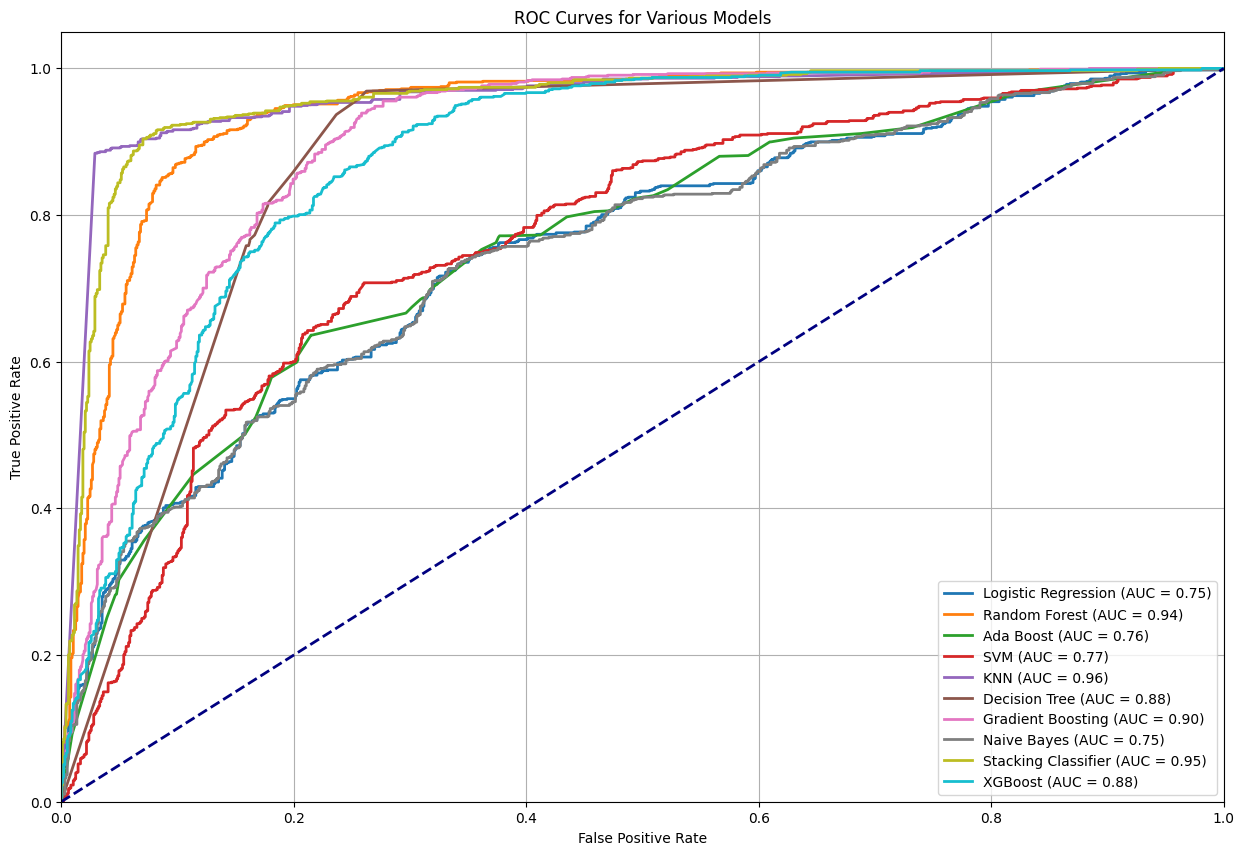

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# List of models and their names
models = {
    'Logistic Regression': best_lr_model,
    'Random Forest': best_rf_model,
    'Ada Boost': best_ab_model,
    'SVM': best_svm_model,
    'KNN': best_knn_model,
    'Decision Tree': best_dt_model,
    'Gradient Boosting': best_gb_model,
    'Naive Bayes': best_nb_model,
    'Stacking Classifier': stacking_model,
    'XGBoost': best_xgb_model
}

# Plot ROC curve for each model
plt.figure(figsize=(15, 10))

for model_name, model in models.items():
    # Check if model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:  # For models without predict_proba, use decision_function or fallback
        try:
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # Normalize to [0, 1]
        except AttributeError:
            continue

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc='lower right')
plt.grid()

# Show plot
plt.show()


In [ ]:
# Function to calculate weighted score for each model
def calculate_weighted_score(metrics_df, weights):
    weighted_scores = {}

    for model in metrics_df.index:
        metrics = metrics_df.loc[model]
        weighted_score = (
            weights['Cost'] * (1 / (metrics['Cost'] + 1e-10)) +  # Use inverse of cost to prefer lower costs
            weights['Geometric Mean'] * metrics['Geometric Mean'] +
            weights['AUC Score'] * metrics['AUC Score'] +
            weights['F1 Score'] * metrics['F1 Score']
        ) / sum(weights.values())  # Normalize by total weight

        weighted_scores[model] = weighted_score

    return weighted_scores

# Define weights
weights = {
    'Cost': 2,
    'Geometric Mean': 1,
    'AUC Score': 1,
    'F1 Score': 1
}

# Calculate weighted scores
weighted_scores = calculate_weighted_score(df_metrics, weights)

# Convert to DataFrame for better readability
df_weighted_scores = pd.DataFrame.from_dict(weighted_scores, orient='index', columns=['Weighted Score'])
df_weighted_scores = df_weighted_scores.sort_values(by='Weighted Score', ascending=False)

df_weighted_scores


Weighted Score
Stacking Classifier        0.353057
Random Forest              0.348642
Gradient Boosting          0.333098
KNN                        0.332775
Decision Tree              0.331811
XGBoost                    0.323141
SVM                        0.287344
Logistic Regression        0.276576
Ada Boost                  0.275217
Naive Bayes                0.264636

#### Extracting Feature Importances

In [ ]:
# Retrieve feature importances from the best models
feature_importances_rf = best_rf_model.feature_importances_ if hasattr(best_rf_model, 'feature_importances_') else np.zeros(X_train.shape[1])
feature_importances_ab = best_ab_model.feature_importances_ if hasattr(best_ab_model, 'feature_importances_') else np.zeros(X_train.shape[1])
feature_importances_dt = best_dt_model.feature_importances_ if hasattr(best_dt_model, 'feature_importances_') else np.zeros(X_train.shape[1])
feature_importances_gb = best_gb_model.feature_importances_ if hasattr(best_gb_model, 'feature_importances_') else np.zeros(X_train.shape[1])
feature_importances_lr = np.abs(best_lr_model.coef_[0]) if hasattr(best_lr_model, 'coef_') else np.zeros(X_train.shape[1])
feature_importances_svm = np.abs(best_svm_model.coef_[0]) if hasattr(best_svm_model, 'coef_') else np.zeros(X_train.shape[1])
feature_importances_stack = np.mean([model.feature_importances_ for model in stacking_model.estimators_ if hasattr(model, 'feature_importances_')], axis=0) if hasattr(stacking_model, 'estimators_') and hasattr(stacking_model.estimators_[0], 'feature_importances_') else np.zeros(X_train.shape[1])
feature_importances_xgb = best_xgb_model.feature_importances_ if hasattr(best_xgb_model, 'feature_importances_') else np.zeros(X_train.shape[1])

# If PCA was used for dimensionality reduction
pca_components = pca.components_.T if 'pca' in globals() and pca is not None else np.eye(X_train.shape[1])  # Ensure pca is defined

# Map feature importances back to original features
original_importances_rf = np.abs(pca_components @ feature_importances_rf)
original_importances_ab = np.abs(pca_components @ feature_importances_ab)
original_importances_dt = np.abs(pca_components @ feature_importances_dt)
original_importances_gb = np.abs(pca_components @ feature_importances_gb)
original_importances_lr = np.abs(pca_components @ feature_importances_lr)
original_importances_svm = np.abs(pca_components @ feature_importances_svm)
original_importances_stack = np.abs(pca_components @ feature_importances_stack)
original_importances_xgb = np.abs(pca_components @ feature_importances_xgb)

# Ensure correct feature names if X has been transformed
# If X was transformed, you should replace X.columns with the correct feature names
feature_names = X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame to display feature importances
df_importances_combined = pd.DataFrame({
    'Feature': feature_names,
    'Importance_AdaBoost': original_importances_ab,
    'Importance_RandomForest': original_importances_rf,
    'Importance_DecisionTree': original_importances_dt,
    'Importance_GradientBoosting': original_importances_gb,
    'Importance_LogisticRegression': original_importances_lr,
    'Importance_SVM': original_importances_svm,
    'Importance_StackingClassifier': original_importances_stack,
    'Importance_XGBoost': original_importances_xgb
}).sort_values(by='Importance_AdaBoost', ascending=False).reset_index(drop=True)

# Display the combined feature importances
df_importances_combined


Feature  Importance_AdaBoost  Importance_RandomForest  \
0              TenureGroup         6.944344e-01             5.746910e-01   
1                   tenure         1.550207e-01             1.271857e-01   
2   IsMonthToMonthContract         1.274207e-01             8.464829e-02   
3         TotalMonthlyCost         1.213477e-01             1.066333e-01   
4             TotalCharges         1.193661e-01             1.049125e-01   
5        StreamingServices         1.111766e-01             1.221403e-01   
6         HasMultipleLines         1.087906e-01             1.149006e-01   
7          ChargesPerMonth         9.116855e-02             9.731760e-02   
8          SupportServices         7.899516e-02             6.782413e-02   
9           MonthlyCharges         7.407971e-02             8.978866e-02   
10             NumServices         6.955291e-02             6.234288e-02   
11          UsesFiberOptic         6.436685e-02             1.084862e-01   
12     MonthlyChargesRatio         3.984818e-02             3.299447e-02   
13            OnlineBackup         3.315485e-02             2.466199e-01   
14    ServiceToTenureRatio         1.837609e-02             1.507469e-02   
15           HasDependents         1.751824e-02             4.037441e-03   
16   UsesElectronicPayment         1.242983e-02             2.665425e-02   
17           SeniorCitizen         4.366536e-17             7.367329e-17   
18         IsSeniorCitizen         5.530217e-26             9.330721e-26   

    Importance_DecisionTree  Importance_GradientBoosting  \
0              5.695652e-01                 5.965845e-01   
1              1.259942e-01                 1.322750e-01   
2              8.281731e-02                 9.246867e-02   
3              1.060034e-01                 1.093236e-01   
4              1.042938e-01                 1.075551e-01   
5              1.226096e-01                 1.201357e-01   
6              1.151621e-01                 1.137834e-01   
7              9.758083e-02                 9.619333e-02   
8              6.734593e-02                 6.986661e-02   
9              9.046111e-02                 8.691648e-02   
10             6.203424e-02                 6.366114e-02   
11             1.103749e-01                 1.004196e-01   
12             3.270108e-02                 3.424758e-02   
13             2.557577e-01                 2.075906e-01   
14             1.493337e-02                 1.567831e-02   
15             4.960182e-03                 9.626624e-05   
16             2.832734e-02                 1.950824e-02   
17             7.495785e-17                 6.818673e-17   
18             9.493410e-26                 8.635848e-26   

    Importance_LogisticRegression  Importance_SVM  \
0                    5.489177e-01             0.0   
1                    1.217556e-01             0.0   
2                    8.600988e-02             0.0   
3                    1.003112e-01             0.0   
4                    9.868767e-02             0.0   
5                    1.091905e-01             0.0   
6                    1.035810e-01             0.0   
7                    8.753034e-02             0.0   
8                    6.417481e-02             0.0   
9                    7.869921e-02             0.0   
10                   5.836092e-02             0.0   
11                   8.992881e-02             0.0   
12                   3.151043e-02             0.0   
13                   1.812106e-01             0.0   
14                   1.443155e-02             0.0   
15                   7.396078e-04             0.0   
16                   1.629894e-02             0.0   
17                   6.106139e-17             0.0   
18                   7.733424e-26             0.0   

    Importance_StackingClassifier  Importance_XGBoost  
0                    6.088188e-01        5.787333e-01  
1                    1.351189e-01        1.281254e-01  
2                    9.683874e-02        8.609219e-02  
3           

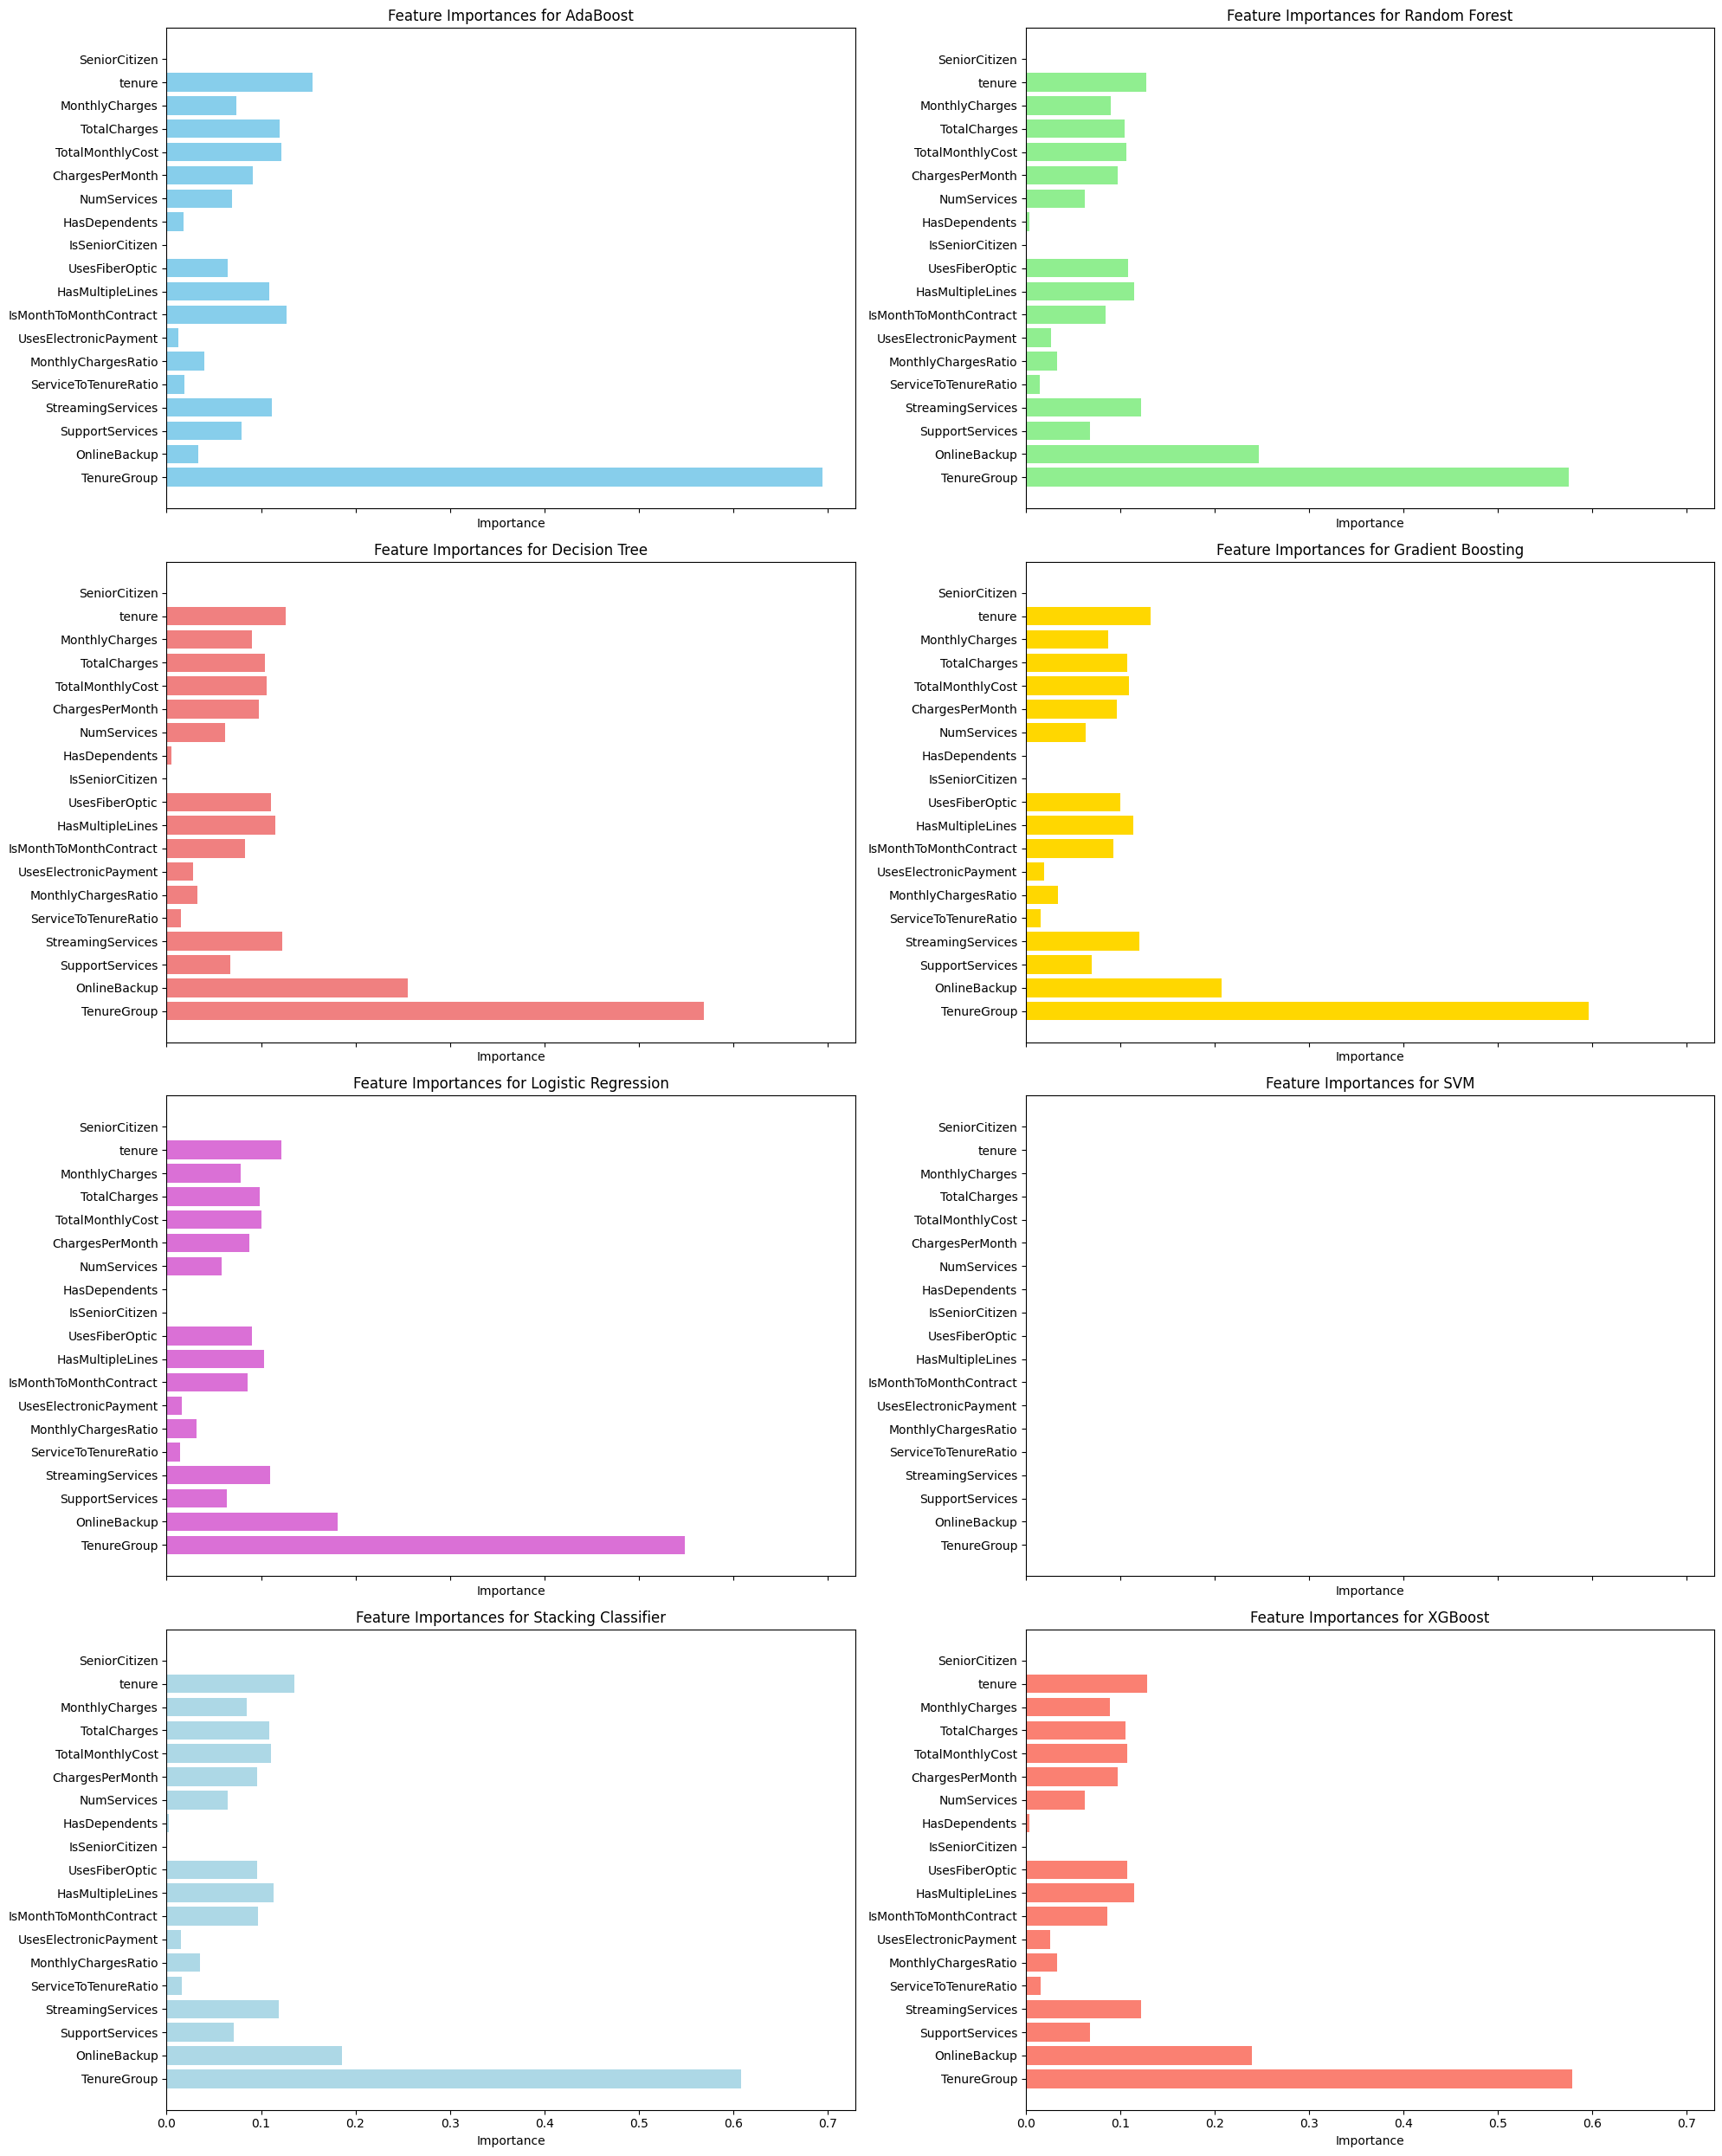

In [ ]:
# Create a DataFrame for feature importances
df_importances_combined = pd.DataFrame({
    'Feature': X.columns,  # Use X_train.columns
    'Importance_AdaBoost': original_importances_ab,
    'Importance_RandomForest': original_importances_rf,
    'Importance_DecisionTree': original_importances_dt,
    'Importance_GradientBoosting': original_importances_gb,
    'Importance_LogisticRegression': original_importances_lr,
    'Importance_SVM': original_importances_svm,
    'Importance_StackingClassifier': original_importances_stack,
    'Importance_XGBoost': original_importances_xgb
}).reset_index(drop=True)

# Create a subplot grid of 4 rows x 2 columns to accommodate all models
fig, axes = plt.subplots(4, 2, figsize=(20, 25), sharex=True)

# Plot AdaBoost feature importances
axes[0, 0].barh(df_importances_combined['Feature'], df_importances_combined['Importance_AdaBoost'], color='skyblue')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Feature Importances for AdaBoost')
axes[0, 0].invert_yaxis()

# Plot Random Forest feature importances
axes[0, 1].barh(df_importances_combined['Feature'], df_importances_combined['Importance_RandomForest'], color='lightgreen')
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Feature Importances for Random Forest')
axes[0, 1].invert_yaxis()

# Plot Decision Tree feature importances
axes[1, 0].barh(df_importances_combined['Feature'], df_importances_combined['Importance_DecisionTree'], color='lightcoral')
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Feature Importances for Decision Tree')
axes[1, 0].invert_yaxis()

# Plot Gradient Boosting feature importances
axes[1, 1].barh(df_importances_combined['Feature'], df_importances_combined['Importance_GradientBoosting'], color='gold')
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Feature Importances for Gradient Boosting')
axes[1, 1].invert_yaxis()

# Plot Logistic Regression feature importances
axes[2, 0].barh(df_importances_combined['Feature'], df_importances_combined['Importance_LogisticRegression'], color='orchid')
axes[2, 0].set_xlabel('Importance')
axes[2, 0].set_title('Feature Importances for Logistic Regression')
axes[2, 0].invert_yaxis()

# Plot SVM feature importances
axes[2, 1].barh(df_importances_combined['Feature'], df_importances_combined['Importance_SVM'], color='salmon')
axes[2, 1].set_xlabel('Importance')
axes[2, 1].set_title('Feature Importances for SVM')
axes[2, 1].invert_yaxis()

# Plot Stacking Classifier feature importances
axes[3, 0].barh(df_importances_combined['Feature'], df_importances_combined['Importance_StackingClassifier'], color='lightblue')
axes[3, 0].set_xlabel('Importance')
axes[3, 0].set_title('Feature Importances for Stacking Classifier')
axes[3, 0].invert_yaxis()

# Plot XGBoost feature importances
axes[3, 1].barh(df_importances_combined['Feature'], df_importances_combined['Importance_XGBoost'], color='salmon')
axes[3, 1].set_xlabel('Importance')
axes[3, 1].set_title('Feature Importances for XGBoost')
axes[3, 1].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

Insights from the plot:
*   Across all models, TenureGroup consistently appears as the most important feature, indicating that the duration of a customer's relationship with the service is a strong indicator of churn.
*   The presence of OnlineBackup as a significant feature across multiple models suggests that customers' decisions about service subscriptions (like online backup) are also crucial in predicting churn.
*    Features like HasDependents and gender_Female are recurrently important, though their significance varies across models.
*   While there are consistent top features, each model also highlights some unique features, suggesting that combining insights from multiple models can provide a more comprehensive understanding of churn predictors.

#### LIME

In [ ]:
import lime
import lime.lime_tabular
import numpy as np

# LIME for explanations and interactive visualizations
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)

# Change index to explain another instance
i = 0

# Specify the number of features to explain
num_features = X.shape[1]  # Adjust this to the desired number of features to display

exp = explainer.explain_instance(X_test[i], best_nb_model.predict_proba, num_features=num_features)

exp.show_in_notebook(show_table=True)

Insights from the plot:
*   The prediction probabilities indicate that the model predicts a 60% probability of "No Churn" and a 40% probability of "Churn" for the selected instance. This gives an overall sense of the model's confidence in its prediction.
*   The value of SeniorCitizen significantly contributes to the prediction of "No Churn".
*   The table shows the features with their respective contributions. Features with higher absolute values have a more significant impact on the prediction.
*   The absence of other critical features likely contributes to a lower probability of churn.




In [ ]:
# Define models
models = {
    'RandomForest': best_rf_model,
    'AdaBoost': best_ab_model,
    'LogisticRegression': best_lr_model,
    'SVM': best_svm_model,
    'KNN': best_knn_model,
    'DecisionTree': best_dt_model,
    'GradientBoosting': best_gb_model,
    'NaiveBayes': best_nb_model,
    'StackingClassifier': stacking_model,  # Added Stacking Classifier
    'XGBoost': best_xgb_model  # Added XGBoost
}

# Function to plot LIME explanation and print positive, non-zero feature importances
def plot_lime_explanation(exp, pca, original_feature_names, X_test_instance, model_name):
    feature_importances = exp.as_list()
    pc_names = [x[0] for x in feature_importances]
    pc_values = [x[1] for x in feature_importances]

    # Initialize the original feature importances
    original_feature_importances = np.zeros(len(original_feature_names))

    # Map PCA components back to original features
    for j, pc in enumerate(pc_names):
        match = re.search(r'PC (\d+)', pc)
        if match:
            pc_index = int(match.group(1)) - 1  # PCA indices are 1-based
        else:
            continue

        if pc_index >= pca.components_.shape[0]:
            continue

        # Accumulate importances for each original feature
        for k in range(len(original_feature_names)):
            # Contribution of each original feature to this PC
            original_feature_importances[k] += pca.components_[pc_index, k] * pc_values[j]

    # Sort and plot
    sorted_importances = sorted(zip(original_feature_names, original_feature_importances), key=lambda x: x[1], reverse=True)
    original_feature_names = [x[0] for x in sorted_importances]
    original_feature_values = [x[1] for x in sorted_importances]

    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=original_feature_values,
        y=original_feature_names,
        orientation='h',
        marker=dict(color='rgba(255, 99, 71, 0.6)',  # Light red/salmon color
                    line=dict(color='rgba(255, 99, 71, 1.0)', width=1)),
        name='Feature Importance'
    ))

    fig.update_layout(
        title=f'LIME Explanation for {model_name}',
        xaxis=dict(title='Feature Importance'),
        yaxis=dict(title='Features'),
        margin=dict(l=200, r=200, t=100, b=100),
        paper_bgcolor='rgb(248, 248, 255)',
        plot_bgcolor='rgb(248, 248, 255)',
        showlegend=False
    )

    fig.show()

    # Print positive, non-zero feature importances
    print(f"Important Features for the Prediction using {model_name}:")
    for feature, importance in zip(original_feature_names, original_feature_values):
        if importance > 0:
            print(f"{feature}: {importance:.7f}")

# Loop through models and generate LIME explanations
for model_name, model in models.items():
    # Check if the model can handle PCA-transformed data
    if hasattr(model, 'predict_proba'):
        # Create LIME explainer
        explainer = lime.lime_tabular.LimeTabularExplainer(
            X_train,
            feature_names=[f'PC {i+1}' for i in range(n_components)],
            class_names=['No Churn', 'Churn'],
            discretize_continuous=True
        )

        # Explain an instance
        i = 0  # Change the index to analyze different instances
        exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=10)

        # Plot the LIME explanation and print positive, non-zero feature importances
        plot_lime_explanation(exp, pca, df_final.drop(columns=['Churn']).columns.tolist(), X_test[i], model_name)
    else:
        print(f"Model {model_name} does not support `predict_proba` or is incompatible with PCA-transformed data.")


Important Features for the Prediction using RandomForest:
MonthlyChargesRatio: 0.0411715
OnlineBackup: 0.0325585
SupportServices: 0.0292164
NumServices: 0.0175427
StreamingServices: 0.0113306
UsesFiberOptic: 0.0103707
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using AdaBoost:
MonthlyChargesRatio: 0.0181782
SupportServices: 0.0176874
OnlineBackup: 0.0161270
NumServices: 0.0064551
UsesFiberOptic: 0.0025057
StreamingServices: 0.0024837
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using LogisticRegression:
MonthlyChargesRatio: 0.0295827
OnlineBackup: 0.0232771
SupportServices: 0.0206732
NumServices: 0.0126910
StreamingServices: 0.0083094
UsesFiberOptic: 0.0075900
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using SVM:
MonthlyChargesRatio: 0.0506021
OnlineBackup: 0.0395199
SupportServices: 0.0345520
NumServices: 0.0219266
StreamingServices: 0.0146398
UsesFiberOptic: 0.0133337
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using KNN:
MonthlyChargesRatio: 0.0518972
OnlineBackup: 0.0430445
SupportServices: 0.0423051
NumServices: 0.0206366
StreamingServices: 0.0114004
UsesFiberOptic: 0.0107006
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using DecisionTree:
MonthlyChargesRatio: 0.0543400
SupportServices: 0.0482358
OnlineBackup: 0.0465119
NumServices: 0.0205461
StreamingServices: 0.0098642
UsesFiberOptic: 0.0094984
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using GradientBoosting:
MonthlyChargesRatio: 0.0366738
OnlineBackup: 0.0302310
SupportServices: 0.0293847
NumServices: 0.0147207
StreamingServices: 0.0083250
UsesFiberOptic: 0.0077829
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using NaiveBayes:
MonthlyChargesRatio: 0.0243504
OnlineBackup: 0.0180558
SupportServices: 0.0139982
NumServices: 0.0112599
StreamingServices: 0.0084280
UsesFiberOptic: 0.0075546
HasMultipleLines: 0.0000739
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using StackingClassifier:
MonthlyChargesRatio: 0.0500560
OnlineBackup: 0.0407312
SupportServices: 0.0386556
NumServices: 0.0204835
StreamingServices: 0.0121264
UsesFiberOptic: 0.0112513
UsesElectronicPayment: 0.0000000


Important Features for the Prediction using XGBoost:
MonthlyChargesRatio: 0.0584246
OnlineBackup: 0.0477330
SupportServices: 0.0456436
NumServices: 0.0237664
StreamingServices: 0.0138774
UsesFiberOptic: 0.0129049
UsesElectronicPayment: 0.0000000


Insights from the plots:


*   Across all models, TenureGroup is consistently the most important feature, highlighting its critical role in predicting customer churn.
*   Features related to services like OnlineBackup, PaperlessBilling, and payment methods are also significant across multiple models.
*   Simplifying billing processes and offering diverse payment options might reduce churn. Encouraging customers to switch to more convenient billing methods could also improve retention rates.
*   Gender appears as a significant feature in some models, suggesting that demographic factors also play a role in churn behavior.
*   Businesses should focus on customers in shorter tenure groups, offering incentives or loyalty programs to extend their duration with the service.
*   Improving and promoting additional services such as online backup could enhance customer retention. Understanding the needs of customers with dependents could also help tailor services and communication strategies.







In [ ]:
import numpy as np
import scipy.optimize as opt

# Function to generate counterfactual explanations
def generate_counterfactual(model, X_instance, predict_proba_func, pca, original_feature_names, threshold=0.5):
    def objective_function(x):
        """Objective function to minimize."""
        prob = predict_proba_func(x.reshape(1, -1))[0, 1]
        return -prob

    def constraint_function(x):
        """Constraint function to ensure the prediction is different from the original."""
        prob = predict_proba_func(x.reshape(1, -1))[0, 1]
        return prob - threshold

    # Initial guess in PCA space
    x0 = X_instance.copy()

    # Define bounds for PCA components (ensure these are valid for PCA space)
    bounds = [(-10, 10) for _ in range(x0.shape[0])]  # Adjust bounds if needed based on PCA component range

    # Define constraints
    constraints = [{'type': 'ineq', 'fun': constraint_function}]

    # Optimize to find counterfactual in PCA space
    result = opt.minimize(objective_function, x0, bounds=bounds, constraints=constraints)

    # Transform back to original feature space
    if pca:
        counterfactual_pca = result.x
        counterfactual = pca.inverse_transform(counterfactual_pca.reshape(1, -1))[0]
    else:
        counterfactual = result.x

    return counterfactual

# Function to display counterfactual explanation
def display_counterfactual(counterfactual, original_features, model_name):
    print(f"Counterfactual explanation for model {model_name}:")
    for feature_name, value in zip(original_features, counterfactual):
        print(f"{feature_name}: {value:.4f}")

# Loop through models and generate counterfactual explanations
for model_name, model in models.items():
    if hasattr(model, 'predict_proba'):
        try:
            # Use PCA-transformed X_test
            X_instance = X_test[0].reshape(1, -1)  # Use already transformed PCA data

            # Generate counterfactual explanation
            counterfactual = generate_counterfactual(
                model,
                X_instance[0],
                model.predict_proba,
                pca,
                df_final.drop(columns=['Churn']).columns.tolist()
            )

            # Display counterfactual explanation
            display_counterfactual(counterfactual, df_final.drop(columns=['Churn']).columns.tolist(), model_name)
        except KeyError as e:
            print(f"KeyError encountered: {e}. Check the data indexing.")
        except ValueError as e:
            print(f"ValueError encountered: {e}. Check the feature dimensions.")
    else:
        print(f"Model {model_name} does not support `predict_proba` or is incompatible with PCA-transformed data.")


Counterfactual explanation for model RandomForest:
const: -0.0000
SeniorCitizen: 0.4476
NumServices: 0.6652
HasDependents: 0.3210
IsSeniorCitizen: 0.3288
UsesFiberOptic: 0.6152
HasMultipleLines: 0.4394
IsMonthToMonthContract: 0.1964
UsesElectronicPayment: 0.0000
MonthlyChargesRatio: 0.7551
StreamingServices: 0.6652
SupportServices: 0.6837
OnlineBackup: 0.5383
Counterfactual explanation for model AdaBoost:
const: -0.0000
SeniorCitizen: 0.4476
NumServices: 0.6652
HasDependents: 0.3210
IsSeniorCitizen: 0.3288
UsesFiberOptic: 0.6152
HasMultipleLines: 0.4394
IsMonthToMonthContract: 0.1964
UsesElectronicPayment: 0.0000
MonthlyChargesRatio: 0.7551
StreamingServices: 0.6652
SupportServices: 0.6837
OnlineBackup: 0.5383
Counterfactual explanation for model LogisticRegression:
const: -0.0000
SeniorCitizen: -1.2236
NumServices: 1.1083
HasDependents: -0.6671
IsSeniorCitizen: -0.6766
UsesFiberOptic: 0.5962
HasMultipleLines: -0.0844
IsMonthToMonthContract: -0.7804
UsesElectronicPayment: 0.0000
Monthl

In [ ]:
import plotly.graph_objects as go

def plot_counterfactual(counterfactual, feature_names, model_name):
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=[value for value in counterfactual],
        y=[name for name in feature_names],
        orientation='h',
        marker=dict(color='rgba(50, 171, 96, 0.6)',
                    line=dict(color='rgba(50, 171, 96, 1.0)', width=1)),
        name='Counterfactual Contribution'
    ))

    fig.update_layout(
        title=f'Counterfactual Explanation for {model_name}',
        xaxis=dict(title='Feature Value'),
        yaxis=dict(title='Features'),
        margin=dict(l=200, r=200, t=100, b=100),
        paper_bgcolor='rgb(248, 248, 255)',
        plot_bgcolor='rgb(248, 248, 255)',
        showlegend=False
    )

    fig.show()

# Example usage:
plot_counterfactual(counterfactual, df_final.drop(columns=['Churn']).columns.tolist(), 'StackingClassifier')


Insights from the plot:
*   The counterfactual explanation plot provides actionable strategies by showing how feature values need to change to alter the prediction. For instance, if increasing TenureGroup is essential to prevent churn, efforts could be made to enhance customer retention and loyalty programs.
*   The plot highlights the features that are most critical for changing the prediction, helping to focus on the most impactful areas for intervention.
*   Based on these insights, the business can implement strategies such as:

1.   Enhancing customer retention programs to increase tenure.
2.   Promoting online backup services to customers who currently do not use them.
3. Simplifying payment methods and encouraging customers to switch to electronic payments.

In [ ]:
X.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'TotalMonthlyCost', 'ChargesPerMonth', 'NumServices', 'HasDependents',
       'IsSeniorCitizen', 'UsesFiberOptic', 'HasMultipleLines',
       'IsMonthToMonthContract', 'UsesElectronicPayment',
       'MonthlyChargesRatio', 'ServiceToTenureRatio', 'StreamingServices',
       'SupportServices', 'OnlineBackup', 'TenureGroup'],
      dtype='object')

In [ ]:
# Save the PCA transformer using joblib
joblib.dump(pca, 'pca_transformer.joblib')

print("PCA transformer saved to 'pca_transformer.pkl'")

PCA transformer saved to 'pca_transformer.pkl'


In [ ]:
# Save the trained stacking model using joblib
joblib.dump(stacking_model, 'stacking_model.joblib')

# Load the model from the joblib file
loaded_stacking_model = joblib.load('stacking_model.joblib')

# Predict on a specific test data point
i = 0  # Index of the test data point you want to predict
X_test_instance = X_test[i].reshape(1, -1)  # Ensure it's in the correct shape for prediction

# Use the loaded model to make predictions
predictions = loaded_stacking_model.predict(X_test_instance)
pred_proba = loaded_stacking_model.predict_proba(X_test_instance)

print(f"Prediction for test data point {i}: {predictions[0]}")
print(f"Prediction probabilities: {pred_proba[0]}")

Prediction for test data point 0: 1
Prediction probabilities: [0.12768775 0.87231225]


In [ ]:
X.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'TotalMonthlyCost', 'ChargesPerMonth', 'NumServices', 'HasDependents',
       'IsSeniorCitizen', 'UsesFiberOptic', 'HasMultipleLines',
       'IsMonthToMonthContract', 'UsesElectronicPayment',
       'MonthlyChargesRatio', 'ServiceToTenureRatio', 'StreamingServices',
       'SupportServices', 'OnlineBackup', 'TenureGroup'],
      dtype='object')

#### Appendix (Rough)

In [ ]:
# import joblib
# import lime
# import lime.lime_tabular
# import plotly.graph_objects as go
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

# # X = df_final.drop(columns=['Churn'])
# # y = df_final['Churn']

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# feature_names = X.columns.tolist()

# #training the RandomForest model
# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(X_train, y_train)

# #LIME for explanations and interactive visualizations
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     X_train.values,
#     feature_names=feature_names,
#     class_names=['No Churn', 'Churn'],
#     discretize_continuous=True
# )

# #change index to explain another instance
# i = 0
# exp = explainer.explain_instance(X_test.values[i], rf_model.predict_proba, num_features=10)

# exp.show_in_notebook(show_table=True)

# def plot_lime_explanation(exp):
#     feature_importances = exp.as_list()
#     feature_names = [x[0] for x in feature_importances]
#     feature_values = [x[1] for x in feature_importances]

#     fig = go.Figure()

#     fig.add_trace(go.Bar(
#         x=feature_values,
#         y=feature_names,
#         orientation='h',
#         marker=dict(color='rgba(50, 171, 96, 0.6)',
#                     line=dict(color='rgba(50, 171, 96, 1.0)', width=1)),
#         name='Feature Importance'
#     ))

#     fig.update_layout(
#         title='LIME Explanation for a Single Instance',
#         xaxis=dict(title='Feature Importance'),
#         yaxis=dict(title='Features'),
#         margin=dict(l=200, r=200, t=100, b=100),
#         paper_bgcolor='rgb(248, 248, 255)',
#         plot_bgcolor='rgb(248, 248, 255)',
#         showlegend=False
#     )

#     fig.show()

# plot_lime_explanation(exp)

#### Neural Network (On Hold)

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import train_test_split

# # Ensure that data segmentation is reasonable
# X_train_res, X_val, y_train_res, y_val = train_test_split(X_train_res, y_train_res, test_size=0.2, random_state=42)

# # Build neural network models
# model = Sequential()
# model.add(Dense(128, input_dim=X_train_res.shape[1], activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Compilation model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Early-stop callback function
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Training models
# history = model.fit(X_train_res, y_train_res, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# # Assessment models
# loss, accuracy = model.evaluate(X_test, y_test)
# print("Neural Network - Accuracy: {}".format(accuracy))

# # Predictions
# nn_preds = (model.predict(X_test) > 0.5).astype("int32")

# def evaluate_model(preds, true_labels):
#     from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
#     accuracy = accuracy_score(true_labels, preds)
#     recall = recall_score(true_labels, preds)
#     f1 = f1_score(true_labels, preds)
#     auc = roc_auc_score(true_labels, preds)
#     cm = confusion_matrix(true_labels, preds)
#     return accuracy, recall, f1, auc, cm

# nn_accuracy, nn_recall, nn_f1, nn_auc, nn_cm = evaluate_model(nn_preds, y_test)
# print("Neural Network - Accuracy: {}, Recall: {}, F1 Score: {}, AUC: {}".format(nn_accuracy, nn_recall, nn_f1, nn_auc))
# print("Confusion Matrix:\n", nn_cm)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Check if the GPU is available
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# # Functions to build neural network models
# def create_model(learning_rate=0.001, dropout_rate=0.5, layer1_units=128, layer2_units=64, layer3_units=32):
#     model = Sequential()
#     model.add(Dense(layer1_units, input_dim=X_train_res.shape[1], activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(layer2_units, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(layer3_units, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Optimal hyperparameter combinations
# best_params = {
#     'batch_size': 32,
#     'epochs': 50,
#     'learning_rate': 0.001,
#     'dropout_rate': 0.5,
#     'layer1_units': 128,
#     'layer2_units': 64,
#     'layer3_units': 32
# }

# # Construct the final model using the best combination of hyperparameters
# best_model = create_model(learning_rate=best_params['learning_rate'], dropout_rate=best_params['dropout_rate'],
#                           layer1_units=best_params['layer1_units'], layer2_units=best_params['layer2_units'],
#                           layer3_units=best_params['layer3_units'])
# best_model.fit(X_train_res, y_train_res, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.2, verbose=2)

# # Evaluate the tuned neural network model
# loss, accuracy = best_model.evaluate(X_test, y_test)
# print("Tuned Neural Network - Accuracy: {}".format(accuracy))

# # Predictions
# nn_preds = (best_model.predict(X_test) > 0.5).astype("int32")

# # Evaluate the tuned neural network model
# nn_accuracy, nn_recall, nn_f1, nn_auc, nn_cm = evaluate_model(nn_preds, y_test)
# print("Tuned Neural Network - Accuracy: {}, Recall: {}, F1 Score: {}, AUC: {}".format(nn_accuracy, nn_recall, nn_f1, nn_auc))
# print("Confusion Matrix:\n", nn_cm)

# # Preservation of the best models
# best_model.save('best_churn_model.h5')


In [ ]:
# import joblib
# import shap
# from sklearn.metrics import confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# # Check if the GPU is available
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# # Preservation of the best models
# best_model.save('best_churn_model.h5')

# # Loading models
# best_model = load_model('best_churn_model.h5')

# # SHAP interpretation using TreeExplainer
# background = shap.sample(X_train_res, 100)
# explainer = shap.DeepExplainer(best_model, background)
# shap_values = explainer.shap_values(X_test)

# # Mapping of SHAP summaries
# shap.summary_plot(shap_values, X_test)

# # Further evaluation of the model # Confusion matrix
# conf_matrix = confusion_matrix(y_test, nn_preds)
# print("Confusion Matrix:\n", conf_matrix)

# # ROC curves and AUC
# fpr, tpr, _ = roc_curve(y_test, nn_preds)
# roc_auc = auc(fpr, tpr)
# print("AUC: ", roc_auc)

# # Plotting ROC curves
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel

# # # Handling of missing values and data type conversions
# # data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
# # data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# # # Constructing new identities
# # data['TenureMonths'] = data['tenure'] * 30

# # Separate target variables and characteristics
# y = df_final['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
# X = df_final.drop(columns=['customerID', 'Churn'])

# # Coding category variables
# X = pd.get_dummies(X, drop_first=True)

# # feature selection
# selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100))
# selector.fit(X, y)
# selected_features = X.columns[(selector.get_support())]
# X_selected = X[selected_features]

# print(f"Selected Features: {selected_features}")

# # Segmented data sets
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# # Train the model and evaluate
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# # Assessment models
# from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# accuracy = accuracy_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(f"Accuracy: {accuracy}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print(f"AUC: {roc_auc}")
# print("Confusion Matrix:\n", conf_matrix)


In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
# from imblearn.over_sampling import SMOTE
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from scikeras.wrappers import KerasClassifier
# from mlxtend.classifier import StackingClassifier

# # # Reload data
# # data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# # # Handling of missing values and data type conversions
# # data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
# # data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# # # Create new features: interactive features
# # data['tenure_monthly_charges'] = data['tenure'] * data['MonthlyCharges']
# # data['total_charges_per_tenure'] = data['TotalCharges'] / (data['tenure'] + 1)

# # Extract features and tags
# X = df_final.drop(columns=['Churn', 'customerID'])
# y = df_final['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# # Coding category variables
# X = pd.get_dummies(X, drop_first=True)

# # Feature scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Feature selection
# selector = SelectKBest(score_func=f_classif, k=15)
# X_selected = selector.fit_transform(X_scaled, y)

# # Characterization of output selection
# selected_features = X.columns[selector.get_support()]
# print("Selected Features: ", selected_features)

# # Data balancing with SMOTE
# smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X_selected, y)

# # Data segmentation
# X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# # Create neural network models
# def create_nn_model(learning_rate=0.001, dropout_rate=0.5, layer1_units=128, layer2_units=64, layer3_units=32, input_dim=15):
#     model = Sequential()
#     model.add(Dense(layer1_units, input_dim=input_dim, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(layer2_units, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(layer3_units, activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
#     return model
# # Packaging neural network models for scikit-learn
# nn_model = KerasClassifier(model=create_nn_model, epochs=50, batch_size=32, verbose=2, learning_rate=0.001, dropout_rate=0.5, layer1_units=128, layer2_units=64, layer3_units=32, input_dim=15)

# # Create other base models
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# # Create meta-learners
# lr_model = LogisticRegression()

# # Create stacked classifiers
# stacked_model = StackingClassifier(classifiers=[rf_model, gb_model, nn_model], meta_classifier=lr_model)

# # Training stacked models
# stacked_model.fit(X_train, y_train)

# # Forecasting and assessment
# stacked_preds = stacked_model.predict(X_test)

# # Assessment models
# stacked_accuracy = accuracy_score(y_test, stacked_preds)
# stacked_recall = recall_score(y_test, stacked_preds)
# stacked_f1 = f1_score(y_test, stacked_preds)
# stacked_auc = roc_auc_score(y_test, stacked_preds)
# stacked_cm = confusion_matrix(y_test, stacked_preds)

# print("Stacked Model - Accuracy: {}, Recall: {}, F1 Score: {}, AUC: {}".format(stacked_accuracy, stacked_recall, stacked_f1, stacked_auc))
# print("Confusion Matrix:\n", stacked_cm)


In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score

# # Define custom cross-validation functions
# def custom_cross_val_score(model, X, y, cv=5):
#     kf = KFold(n_splits=cv, shuffle=True, random_state=42)
#     scores = []

#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         score = accuracy_score(y_test, y_pred)
#         scores.append(score)

#     return np.array(scores)

# # Evaluate stacked models using custom cross-validation functions
# cv_scores = custom_cross_val_score(stacked_model, X_res, y_res, cv=5)
# print(f"Custom Cross-Validation Accuracy Scores: {cv_scores}")
# print(f"Mean Custom Cross-Validation Accuracy: {np.mean(cv_scores)}")


In [ ]:

# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from alibi.explainers import Counterfactual, CounterfactualProto


# # Fit a model (example: RandomForest)
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train_scaled, y_train)

# # Initialize the Counterfactual explainer
# shape = (1,) + X_train_scaled.shape[1:]
# cf = Counterfactual(model.predict, shape=shape, target_proba=1.0, tol=0.01,
#                     lam_init=0.01, early_stop=50,
#                     learning_rate_init=0.1, feature_range=(X_train_scaled.min(axis=0),
#                     X_train_scaled.max(axis=0)))

# # Select a sample for which to generate a counterfactual explanation
# X_test_sample = X_test_scaled[0].reshape(1, -1)

# # Generate a counterfactual explanation
# explanation = cf.explain(X_test_sample)

# # Display the original and counterfactual instances
# print("Original instance:", scaler.inverse_transform(X_test_sample))
# print("Counterfactual instance:", scaler.inverse_transform(explanation.cf['X']))

# # To visualize the changes, you can compare the original and counterfactual instances
# df_original = pd.DataFrame(scaler.inverse_transform(X_test_sample), columns=X.columns)
# df_counterfactual = pd.DataFrame(scaler.inverse_transform(explanation.cf['X']), columns=X.columns)

# print("Original instance:\n", df_original)
# print("Counterfactual instance:\n", df_counterfactual)